In [1]:
pip install pandas matplotlib numpy nltk seaborn sklearn gensim pyldavis wordcloud spacy textstat altair beautifulsoup4 Unidecode

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import string
from collections import Counter, defaultdict

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import STOPWORDS, WordCloud
import altair as alt
from bs4 import BeautifulSoup
import json
from unidecode import unidecode

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /Users/Mehdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Mehdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Mehdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Mehdi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
class TextProcessing():
    with open('data/contraction.json', 'r') as ctr:
        contractions = json.load(ctr)
    
    def __init__(self, raw_path:str):
        self.df= pd.read_csv(raw_path)
    
    def addMetaInformation(self, desc:str="Description_processed") -> None:
        self.df["desc_len_char"] = self.df[desc].str.len()
        self.df["desc_len"] = self.df[desc].str.split().map(lambda x: len(x))
        self.df["avg_word_len"] = self.df[desc].str.split().\
            apply(lambda x : [len(i) for i in x]). \
            map(lambda x: np.mean(x))
    
    def filterInformation(self, word_len_boundaries:tuple = (4,9),  desc:str="Description_processed", word_len_column:str="avg_word_len", language_col:str="language") -> None :
        regex_to_detect = 'We are checking your browser'
        self.df = self.df[
            (self.df[word_len_column] > word_len_boundaries[0]) &
            (self.df[word_len_column] < word_len_boundaries[1]) &
            (self.df[word_len_column] < word_len_boundaries[1]) &
            (self.df["language"]=="en") &
            (self.df[desc].apply(lambda x: re.search(regex_to_detect,x, re.IGNORECASE)).isnull() == True)
        ].drop_duplicates(subset=[desc])
    
    def transformDesc(self, ser:pd.Series) -> None :
        ser = ser.\
            apply(lambda x: x.lower()).\
            apply(lambda x: unidecode(x)).\
            apply(lambda x: x.replace('\\n', ' ').\
                    replace('\n', ' ').\
                    replace('\t',' ').\
                    replace('\\', ' ').\
                    replace('. com', '.com')
                ).\
            apply(lambda x: re.sub(r"(^|\W)\d+", "", x)).\
            apply(lambda x: re.sub('\s+',' ',x)).replace('?', ' ? ').replace(')', ') ').\
            apply(lambda x: re.sub(r"\ [A-Za-z]*\.com", " ", x)).\
            apply(lambda x: re.sub(r'http\S+', '', x)).\
            apply(lambda x: self.removeHTMLtags(x)).\
            apply(lambda x: self.expand_contractions(x))
        return ser

    def removeHTMLtags(self, text:str) -> str:
         soup = BeautifulSoup(text, "html.parser")
         stripped_text = soup.get_text(separator=" ")
         return stripped_text

    def expand_contractions(self, text, contractions:dict=contractions):
        tokens = text.split(' ')
        for token in tokens:
            if token in contractions.keys():
                tokens = [item.replace(token, contractions[token]) for item in tokens]
        sentence = ' '.join(str(e) for e in tokens)
        return sentence

<>:36: DeprecationWarning: invalid escape sequence \s
<>:36: DeprecationWarning: invalid escape sequence \s
/var/folders/t9/9z34j5y929zcjx0tmn12ll_r0000gn/T/ipykernel_23316/1695335195.py:36: DeprecationWarning: invalid escape sequence \s
  apply(lambda x: re.sub('\s+',' ',x)).replace('?', ' ? ').replace(')', ') ').\


In [4]:
class EDA_preparation():
    
    def __init__(self, text:pd.Series):
        text_list = text.str.split()
        text_list = text.values.tolist()
        self.corpus_full=[word for i in text_list for word in i.split()]
        self.stop=set(stopwords.words('english'))
        self.corpus_lem = self._preprocess_text(text)
        self.gensim_dic = gensim.corpora.Dictionary(self.corpus_lem)
        self.bow_corpus = [self.gensim_dic.doc2bow(doc) for doc in self.corpus_lem]
    
    def _preprocess_text(self, text:list) -> list[str]:
        corpus=[]
        #stem=PorterStemmer()
        lem = WordNetLemmatizer()
        for doc in text:
            words=[w.lower() for w in word_tokenize(doc) if (w not in self.stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            corpus.append(words)
        return corpus


In [5]:
class EDA__methods():
    stop=set(stopwords.words('english'))
    stop.add("doi")
    
    def top_stopwords_barchart(self, corpus:list, top_words:int=10) -> list[tuple[str,int]]:
        dic=defaultdict(int)
        for word in corpus:
            if word in self.stop:
                dic[word]+=1
        top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:top_words] 
        return top
    
    def top_non_stopwords_barchart(self, corpus:list,top_words:int=60) -> list[tuple[str,int]]: 
        counter=Counter(corpus)
        most=counter.most_common()
        x, y=[], []
        for word,count in most[:top_words]:
            if (word not in self.stop) & (word not in string.punctuation):
                x.append(word)
                y.append(count)
        return list(zip(x, y))
    
    def get_top_ngram(self, corpus:list, n:int=3) -> list[tuple]:
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
            for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:25]

    def get_lda_objects(self, gensim_dic: gensim.corpora.Dictionary ,bow_corpus: gensim.corpora.Dictionary.doc2bow, num_topics:int=20) -> gensim.models.LdaMulticore:            
        lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                    num_topics = num_topics, 
                                    id2word = gensim_dic,                                    
                                    passes = 10,
                                    workers = 2)
        return lda_model
                                    
    def plot_lda_vis(self, lda_model: gensim.models.LdaMulticore, gensim_dic: gensim.corpora.Dictionary ,bow_corpus: gensim.corpora.Dictionary.doc2bow) -> gensimvis:
        pyLDAvis.enable_notebook()
        vis = gensimvis.prepare(lda_model, self.bow_corpus, self.gensim_dic)
        return vis
    
    def get_wordcloud(self, corpus) -> WordCloud:
        wordcloud = WordCloud(
            background_color='white',
            stopwords=self.stop,
            max_words=100,
            max_font_size=30,
            scale=3,
            random_state=1)
    
        wordcloud = wordcloud.generate(corpus)
        return wordcloud

In [6]:
""" # Processing and cleaning the data set cell.
raw = TextProcessing("data/jobDescription.csv")
raw.df["Description_processed"] = raw.transformDesc(raw.df["Description"])
raw.addMetaInformation()
raw.filterInformation()
raw.df.to_pickle("data/jobDescription.pkl") """

' # Processing and cleaning the data set cell.\nraw = TextProcessing("data/jobDescription.csv")\nraw.df["Description_processed"] = raw.transformDesc(raw.df["Description"])\nraw.addMetaInformation()\nraw.filterInformation()\nraw.df.to_pickle("data/jobDescription.pkl") '

In [7]:
quantile:float=.90
raw = pd.read_pickle("data/jobDescription.pkl")
removed_outliers = raw[raw["desc_len_char"] <= raw["desc_len_char"].quantile(quantile)]

In [8]:
raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27610 entries, 1 to 30694
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   board                  27610 non-null  object 
 1   searched_title         27610 non-null  object 
 2   title                  27610 non-null  object 
 3   searched_location      27610 non-null  object 
 4   location               27610 non-null  object 
 5   job_id                 27610 non-null  object 
 6   link                   27610 non-null  object 
 7   host                   27610 non-null  object 
 8   company                27610 non-null  object 
 9   date                   27610 non-null  object 
 10  Description            27610 non-null  object 
 11  language               27610 non-null  object 
 12  Description_processed  27610 non-null  object 
 13  desc_len_char          27610 non-null  int64  
 14  desc_len               27610 non-null  int64  
 15  av

In [9]:
sns.set(rc = {'figure.figsize':(15,10), "figure.dpi":300, 'savefig.dpi':300})
sns.set_palette("icefire")

[Text(0.5, 1.0, 'Character Length Histogram'),
 Text(0.5, 0, 'Number of characters per document'),
 Text(0, 0.5, 'Frequency')]

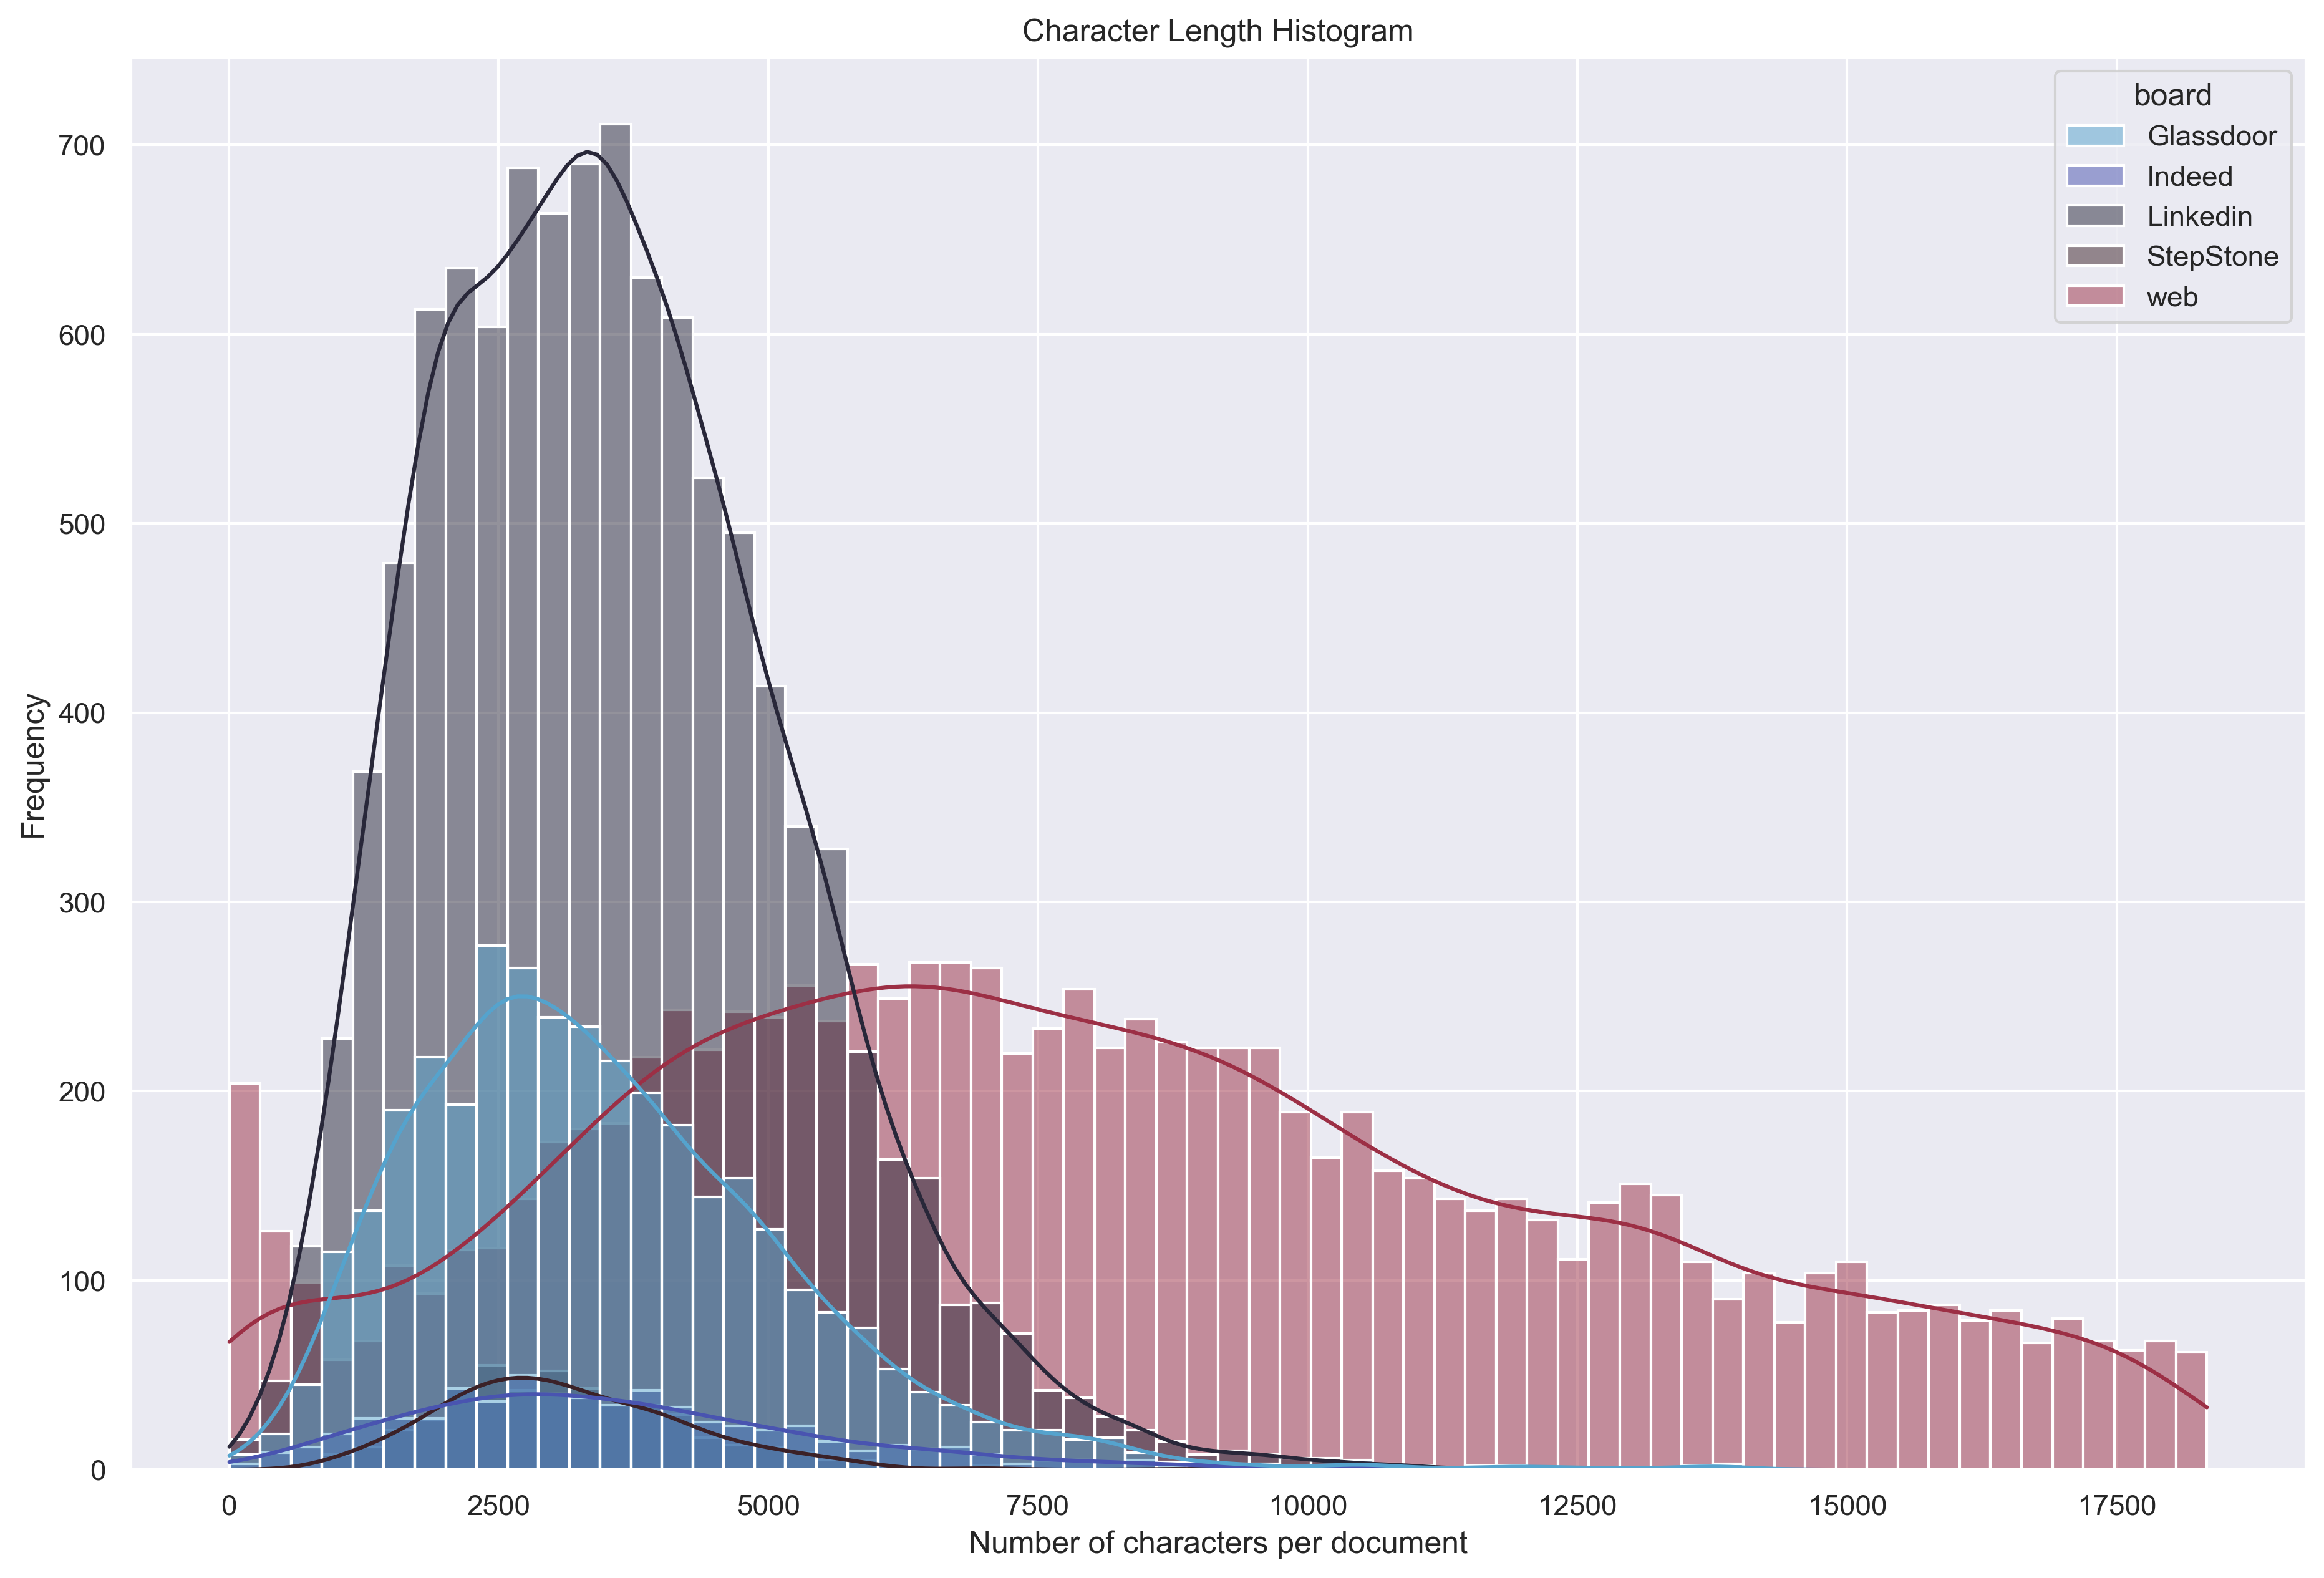

In [10]:
#removed_outliers["desc_len_char"].plot.hist()
sns.\
    histplot(
        data=removed_outliers, 
        x="desc_len_char", 
        kde=True, 
        hue="board").\
        set(
            title='Character Length Histogram',
            xlabel='Number of characters per document', 
            ylabel='Frequency')


[Text(0.5, 1.0, 'Record Length (in word number) Histogram'),
 Text(0.5, 0, 'Number of words per document'),
 Text(0, 0.5, 'Frequency')]

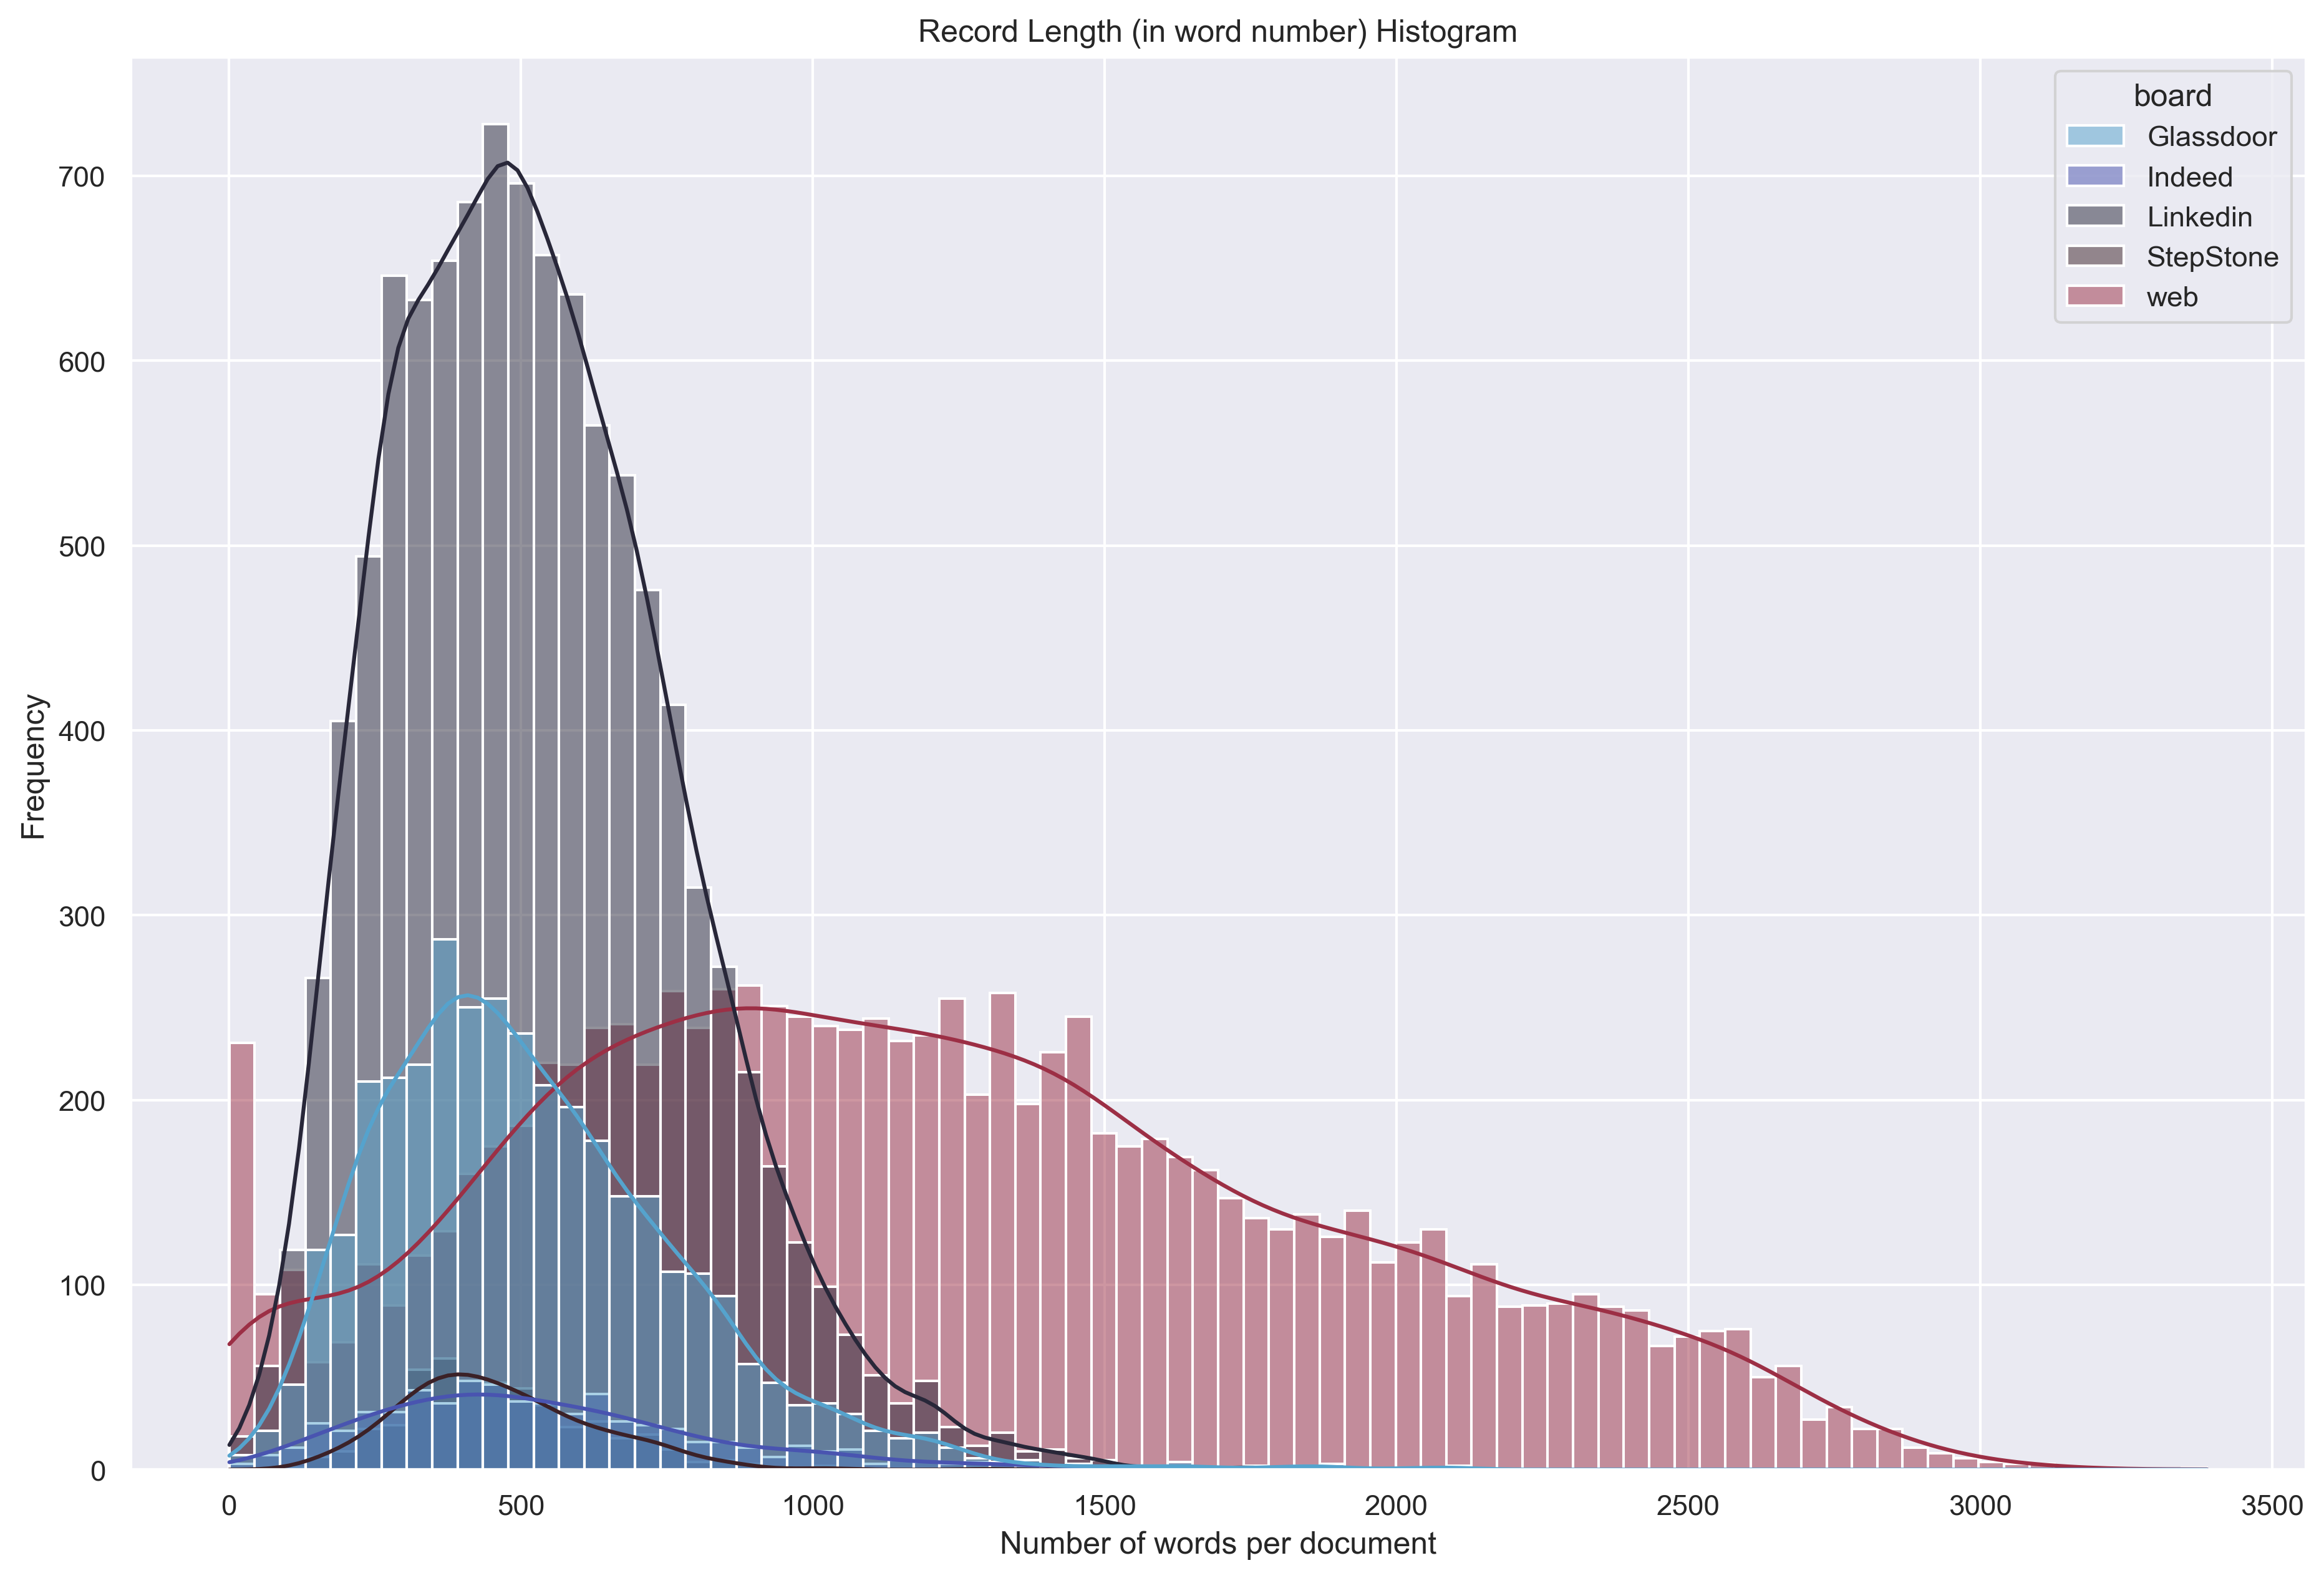

In [11]:
#removed_outliers["desc_len"].plot.hist()

sns.\
    histplot(
        data=removed_outliers, 
        x="desc_len", 
        kde=True, 
        hue="board").\
        set(
            title='Record Length (in word number) Histogram',
            xlabel='Number of words per document', 
            ylabel='Frequency')


[Text(0.5, 1.0, 'Average Word Length Histogram'),
 Text(0.5, 0, 'Average word length'),
 Text(0, 0.5, 'Frequency')]

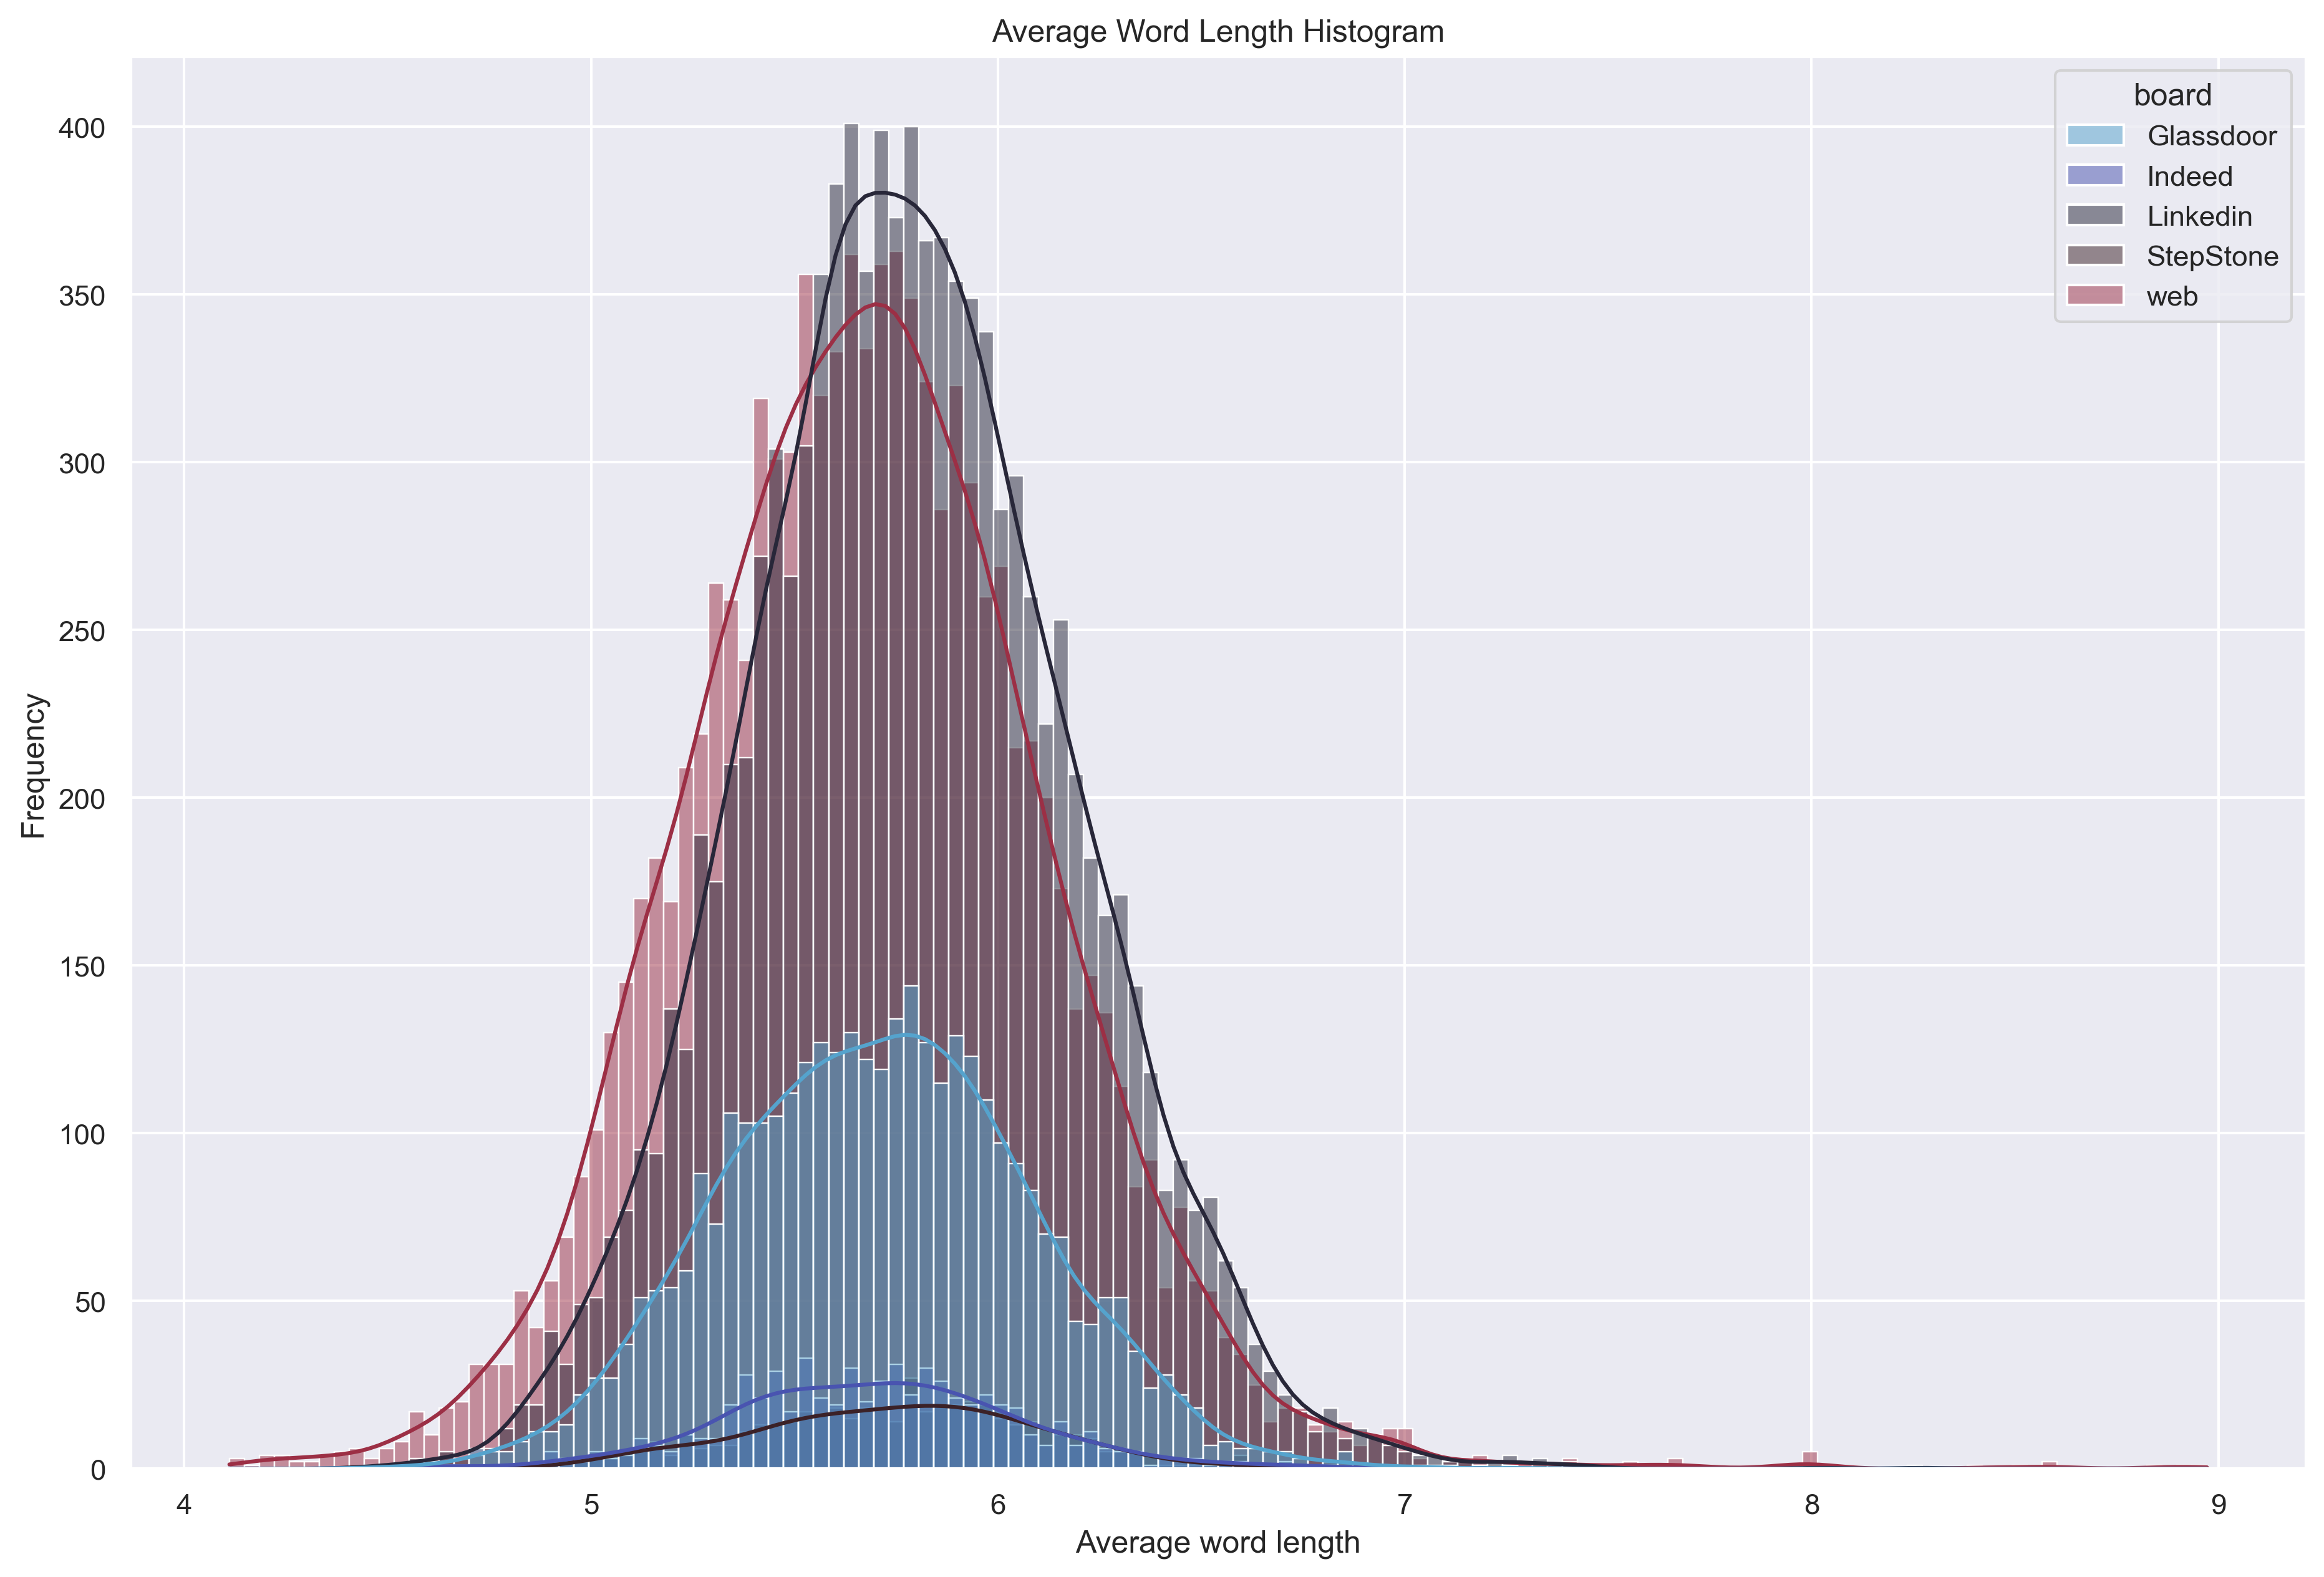

In [12]:
#removed_outliers["avg_word_len"].plot.hist()

sns.\
    histplot(
        data=removed_outliers, 
        x="avg_word_len", 
        kde=True, 
        hue="board").\
        set(
            title='Average Word Length Histogram',
            xlabel='Average word length', 
            ylabel='Frequency')

In [13]:
eda = EDA_preparation(raw['Description_processed'])

In [14]:
print("Corpus Len", len(eda.corpus_full))
print("Number of Distinct words", len(set(eda.corpus_full)))
print("Number of Rec", len(raw))
print("Token per Record", len(eda.corpus_full)/len(raw))
print("Token Usability", len(eda.corpus_full)/len(set(eda.corpus_full)))

Corpus Len 40852739
Number of Distinct words 722151
Number of Rec 27610
Token per Record 1479.635603042376
Token Usability 56.57090968509356


In [15]:
eda_methods = EDA__methods()

In [16]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2e}'.format(p.get_height())

                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2e}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Stopword')]

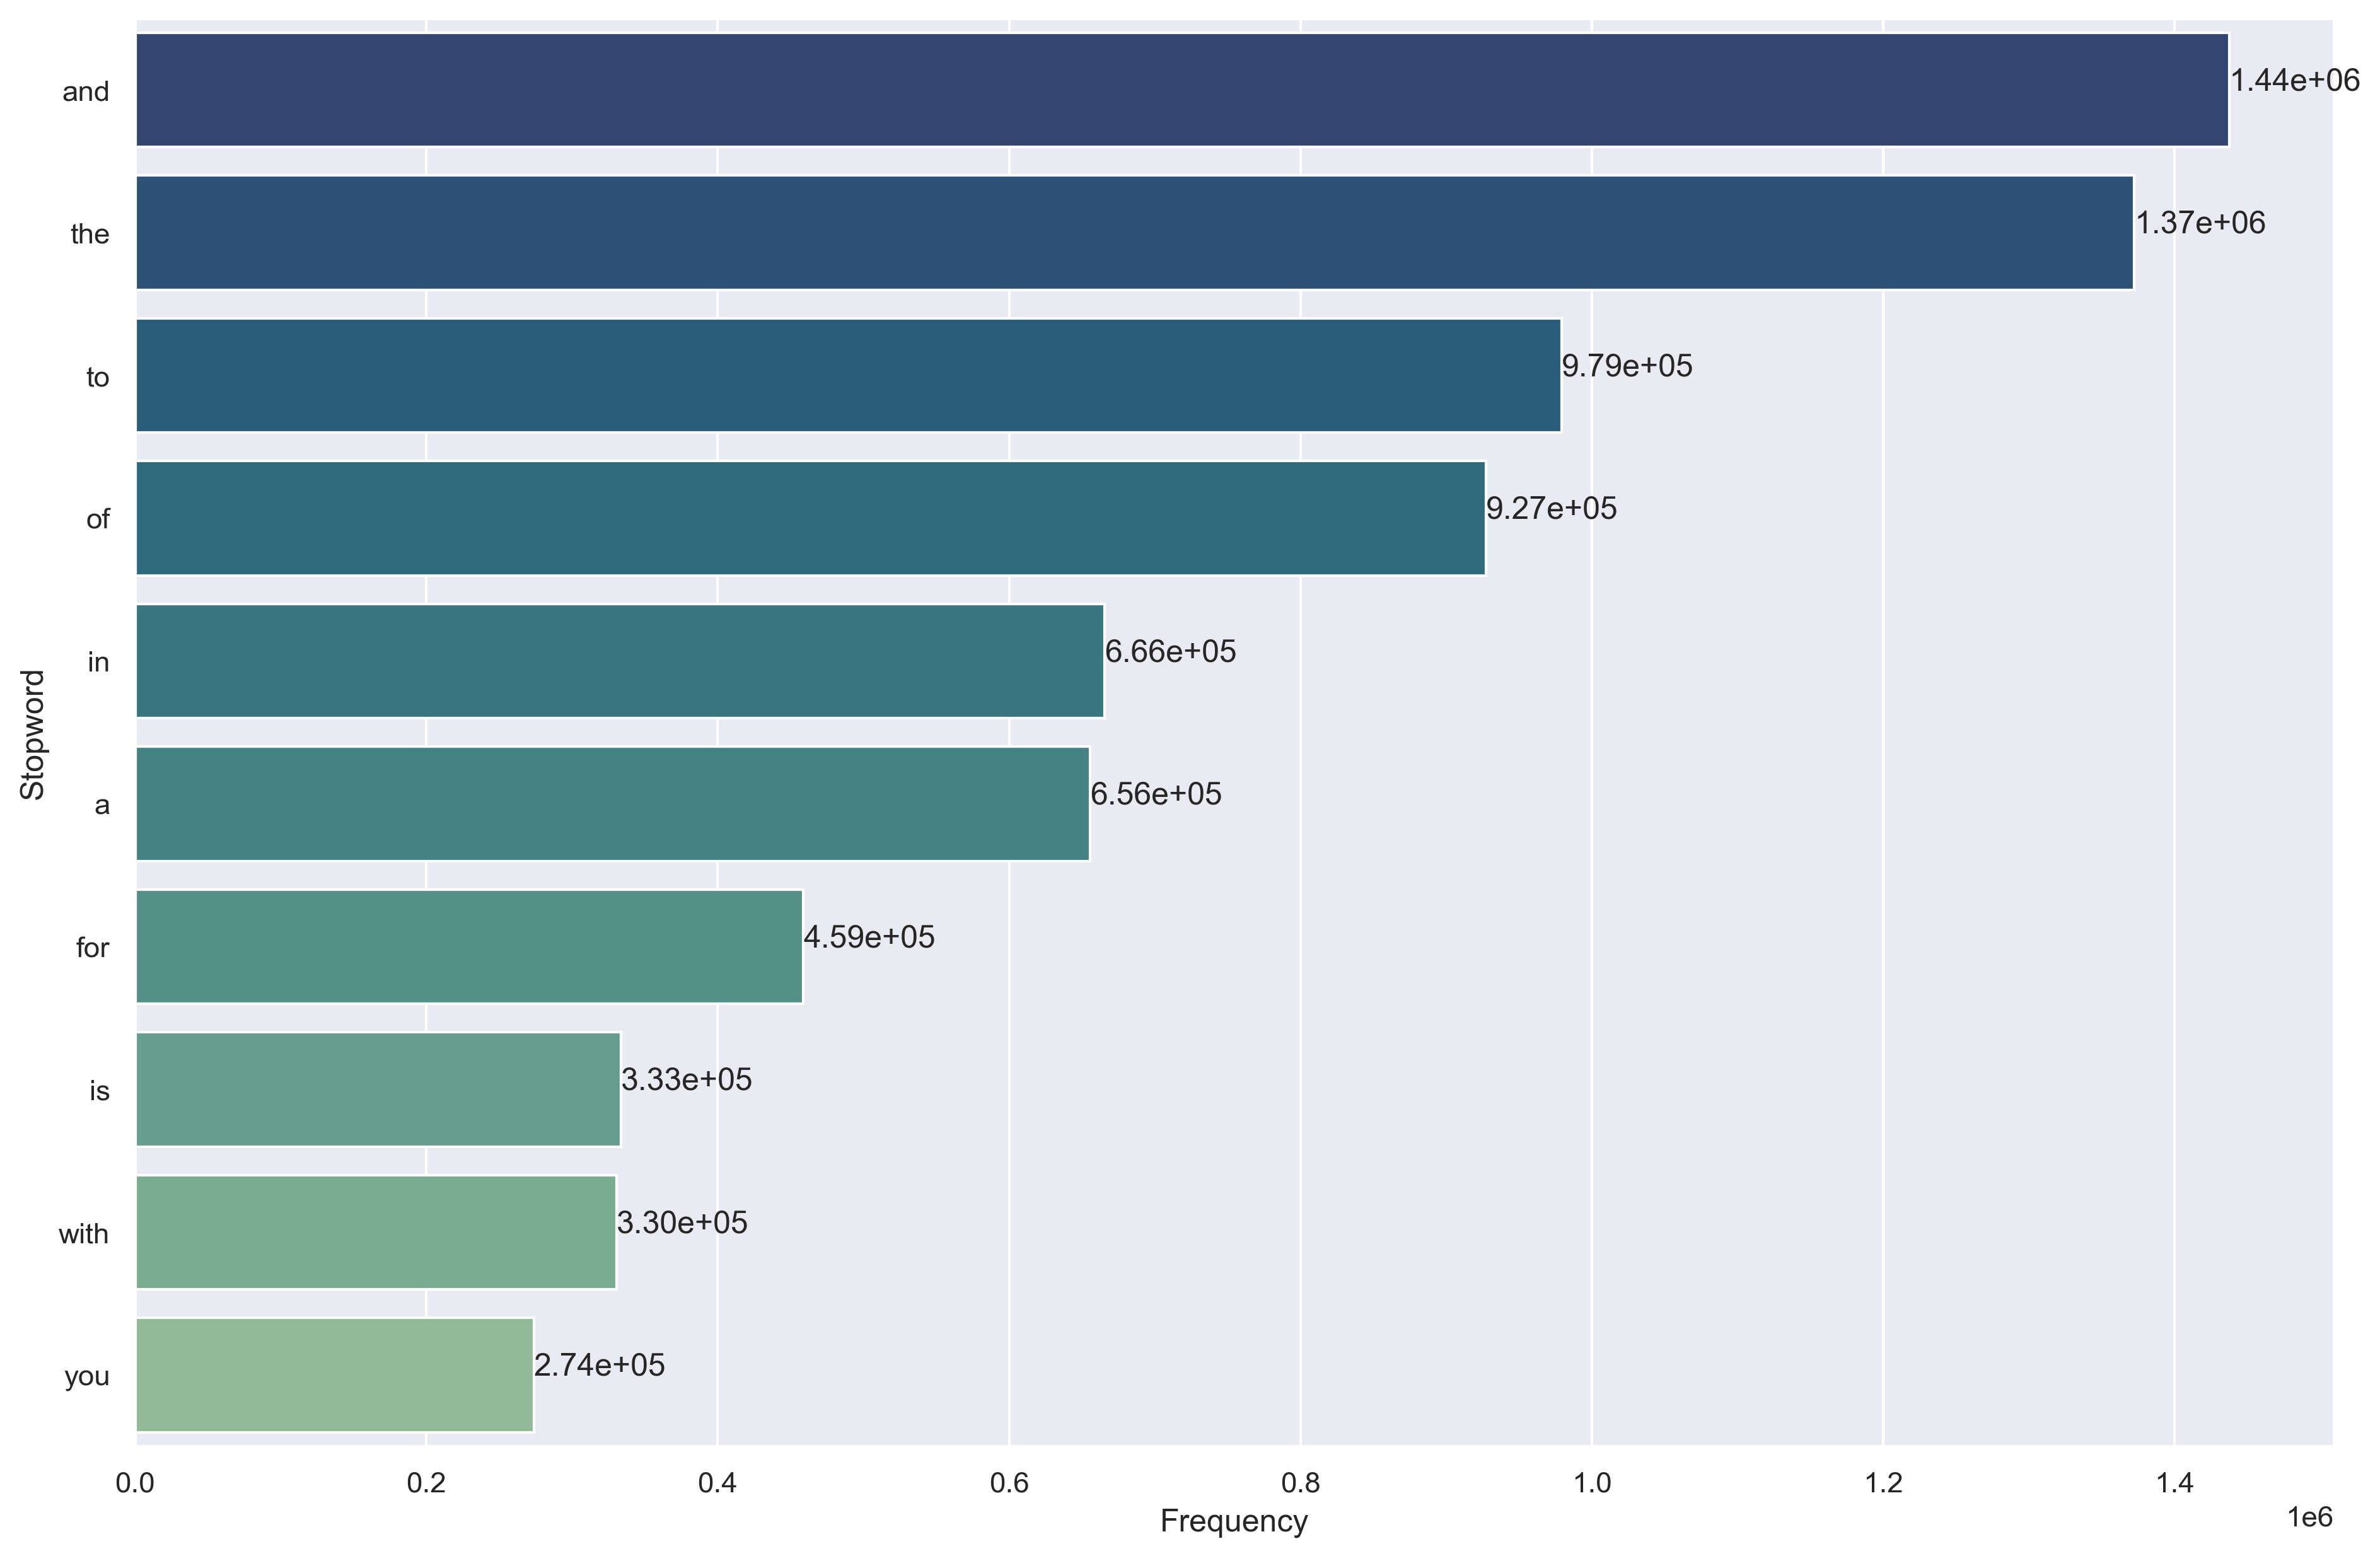

In [17]:
stopword = eda_methods.top_stopwords_barchart(eda.corpus_full)

ax = sns.\
    barplot(
        data=pd.DataFrame(stopword, columns=["Stopword", "Frequency"]), 
        y="Stopword", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='Stopword')



[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token')]

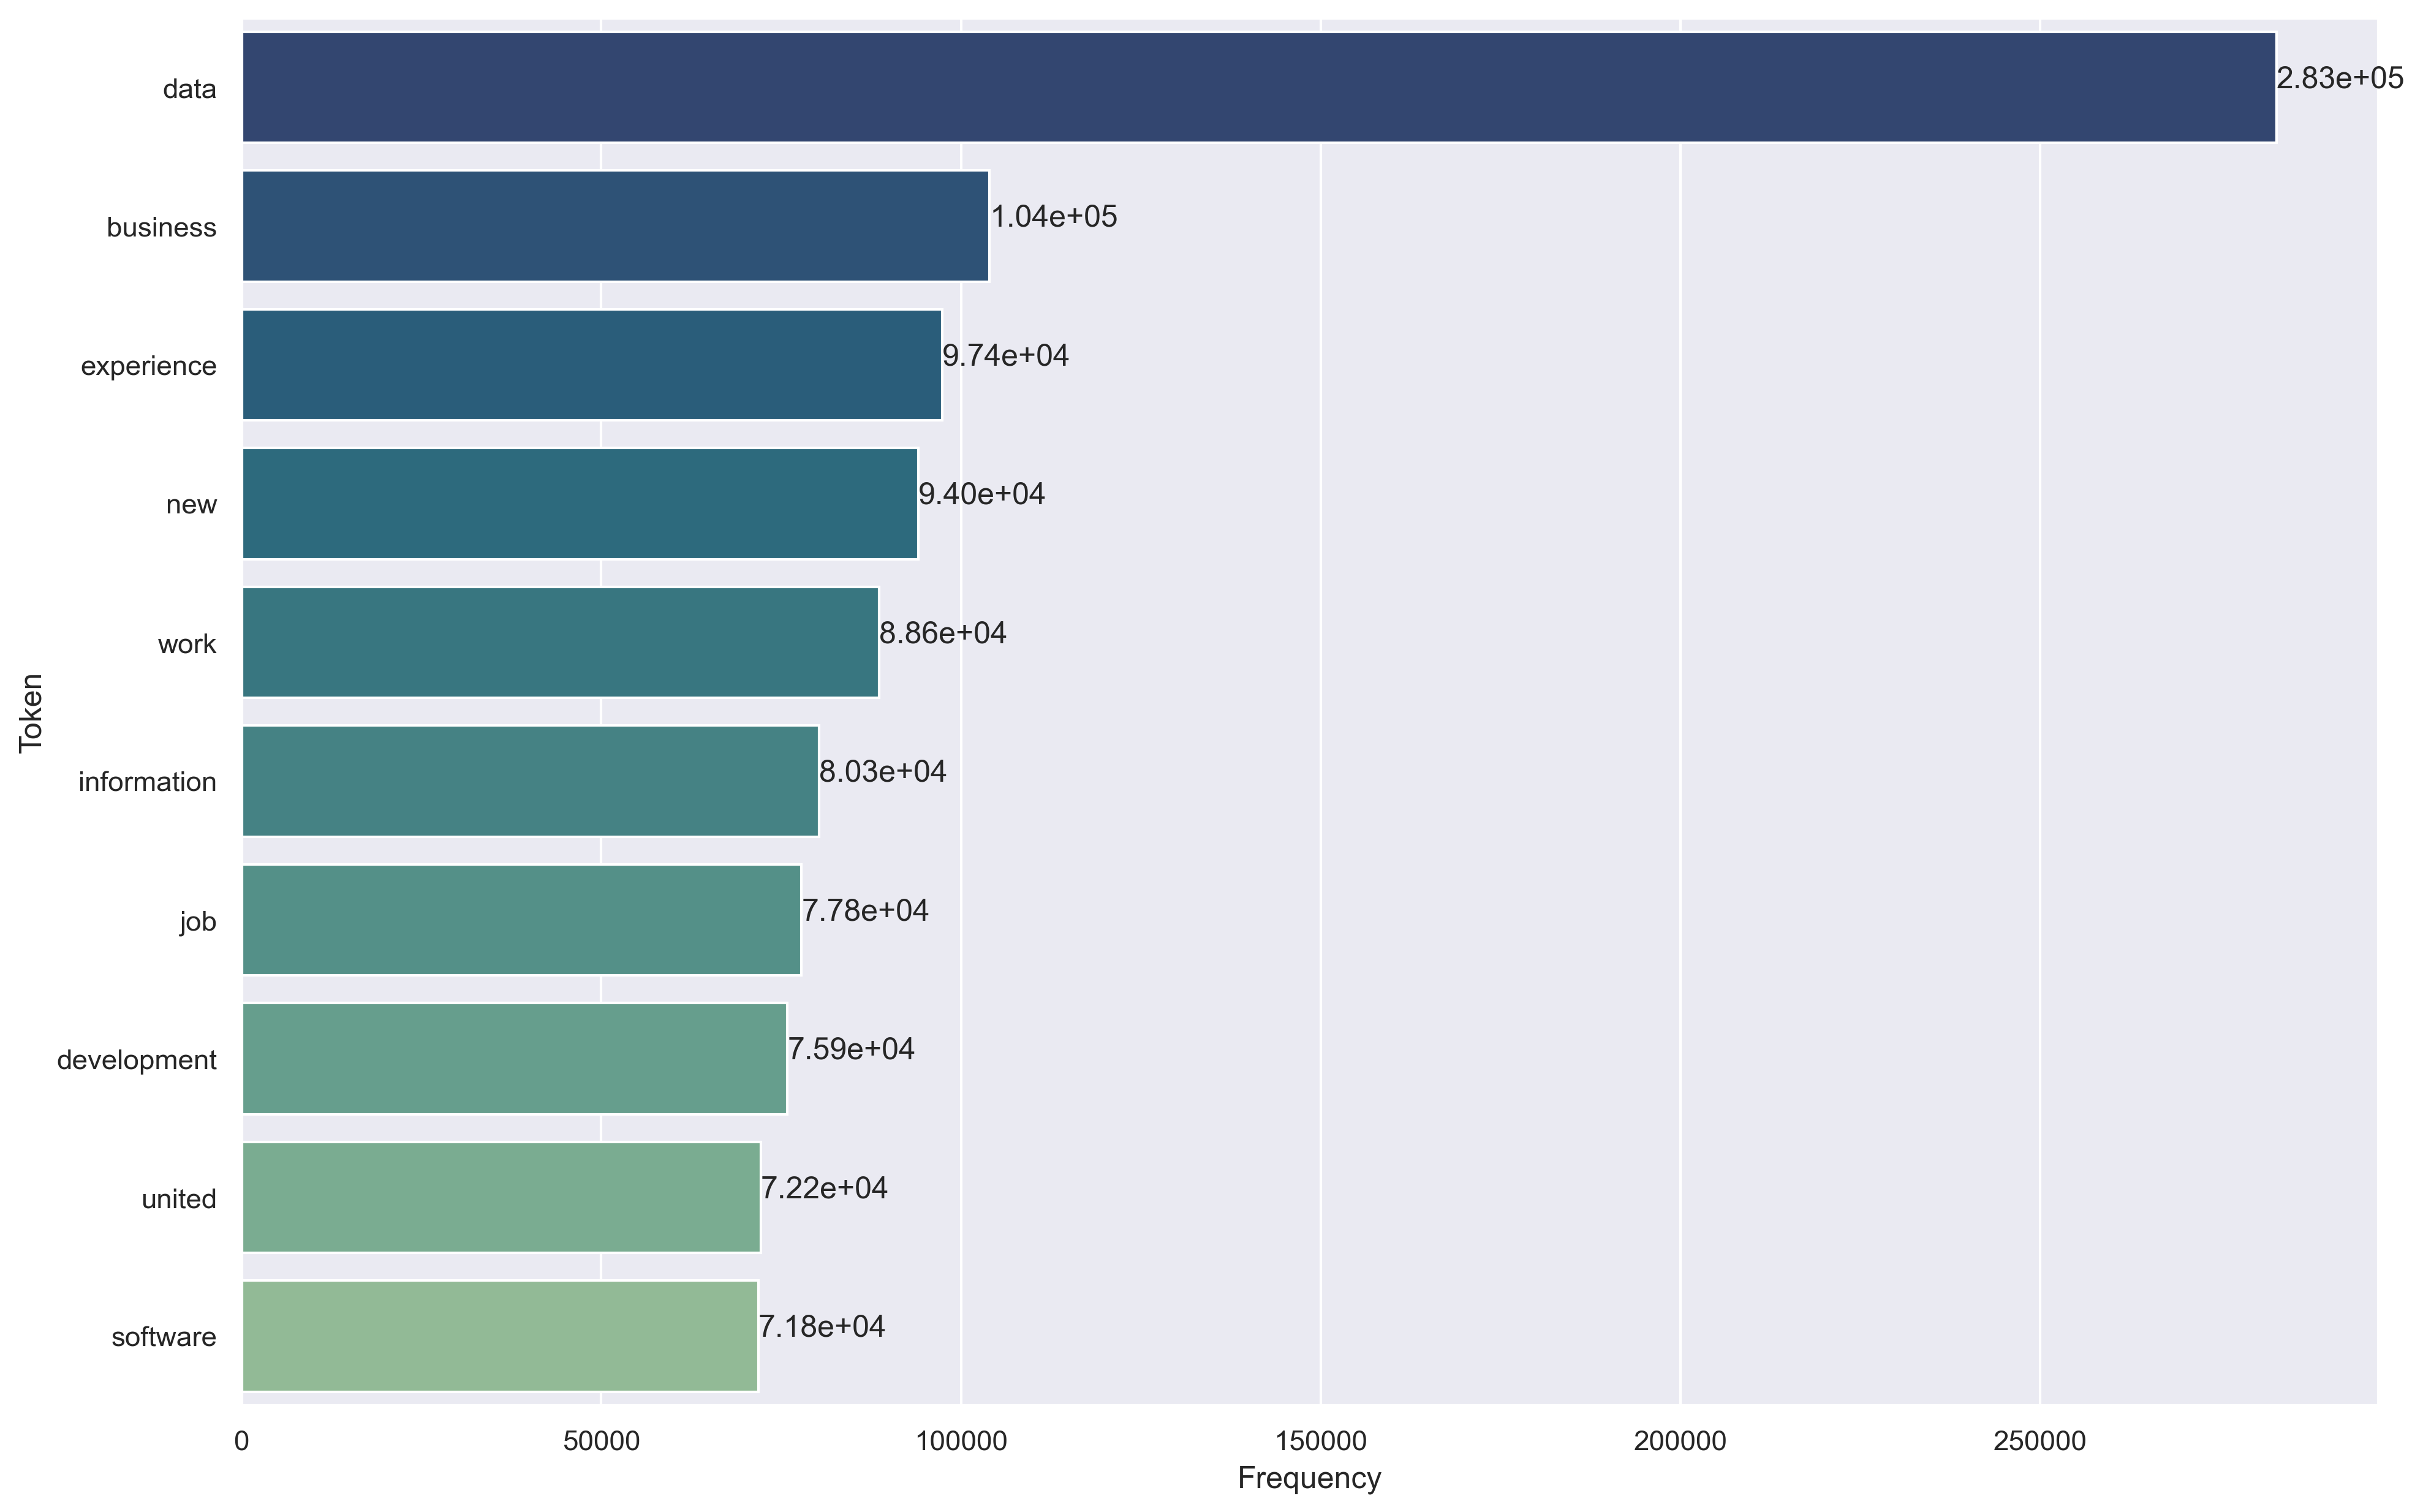

In [18]:
NS = eda_methods.top_non_stopwords_barchart(eda.corpus_full)

ax = sns.\
    barplot(
        data=pd.DataFrame(NS[:10], columns=["Token", "Frequency"]), 
        y="Token", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='Token')


In [19]:
top_n_bigrams = eda_methods.get_top_ngram(eda.corpus_full, 2)
#print(top_n_bigrams)
#x,y=map(list,zip(*top_n_bigrams))
#sns.barplot(x=y,y=x)

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Bigram (N=2)')]

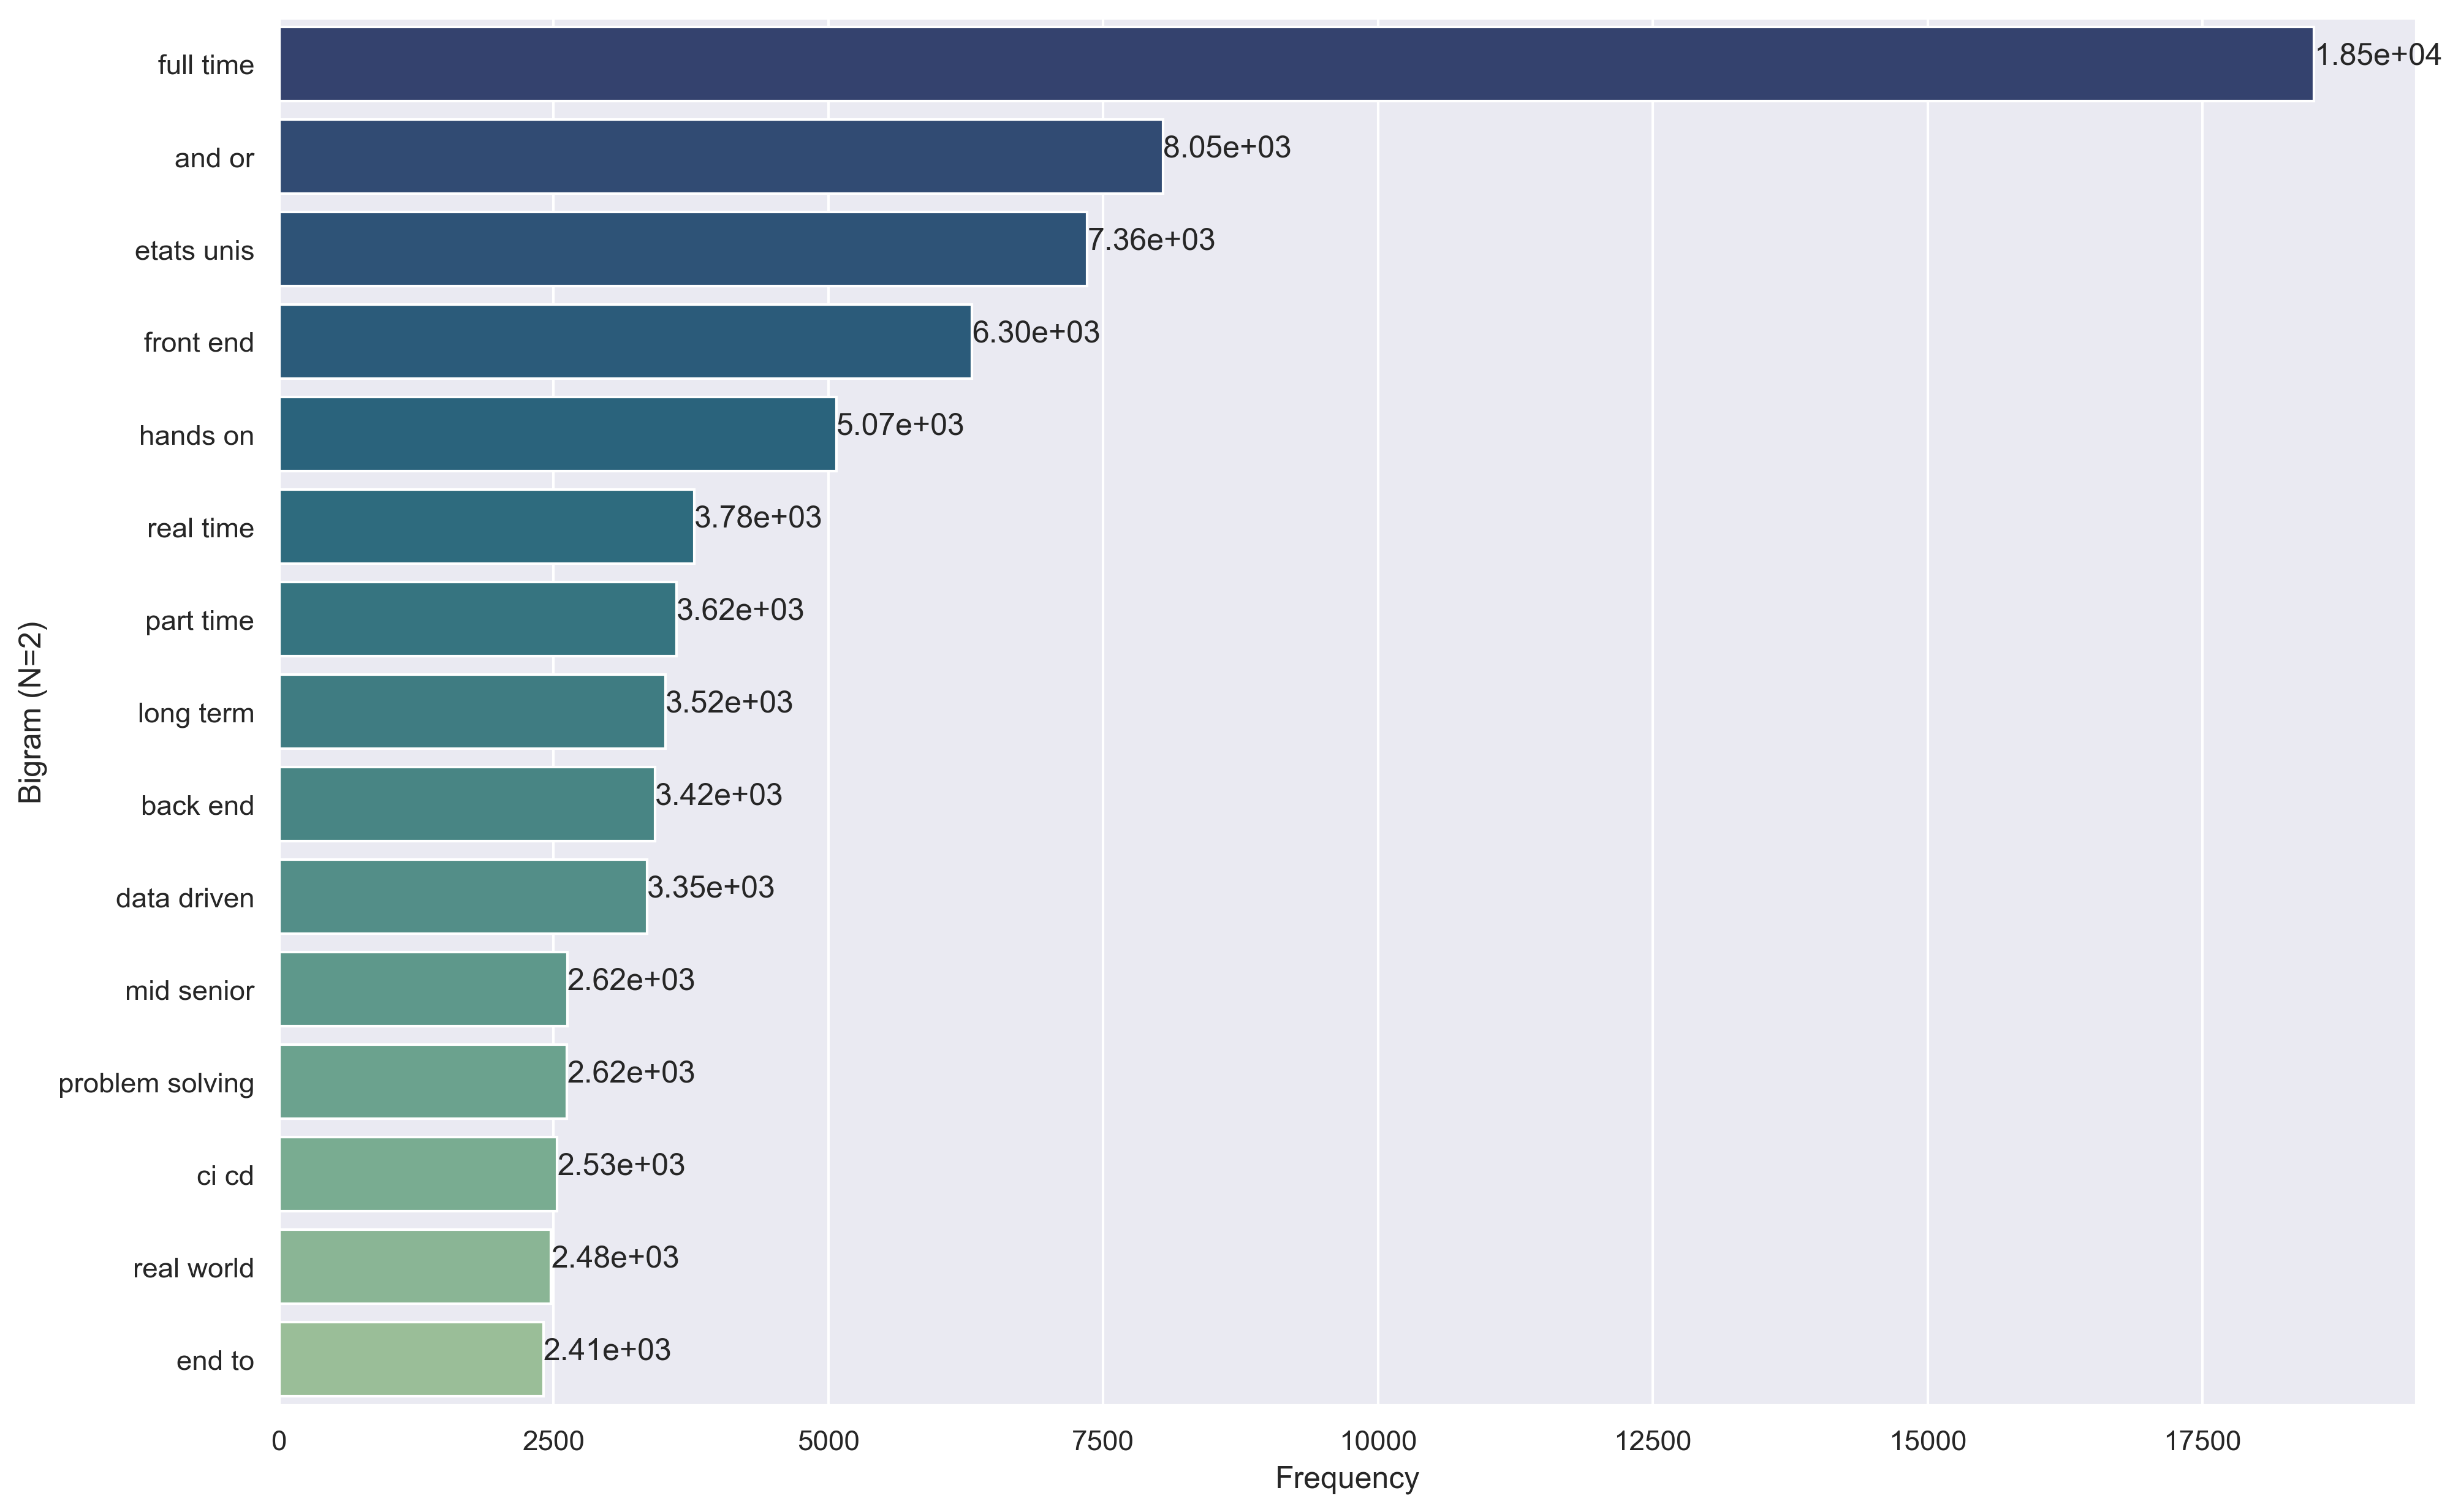

In [20]:

ax = sns.\
    barplot(
        data=pd.DataFrame(top_n_bigrams[:15], columns=["Bigram", "Frequency"]), 
        y="Bigram", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='Bigram (N=2)')

In [21]:
top_n_trigrams = eda_methods.get_top_ngram(eda.corpus_full, 3)

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Trigram (N=3)')]

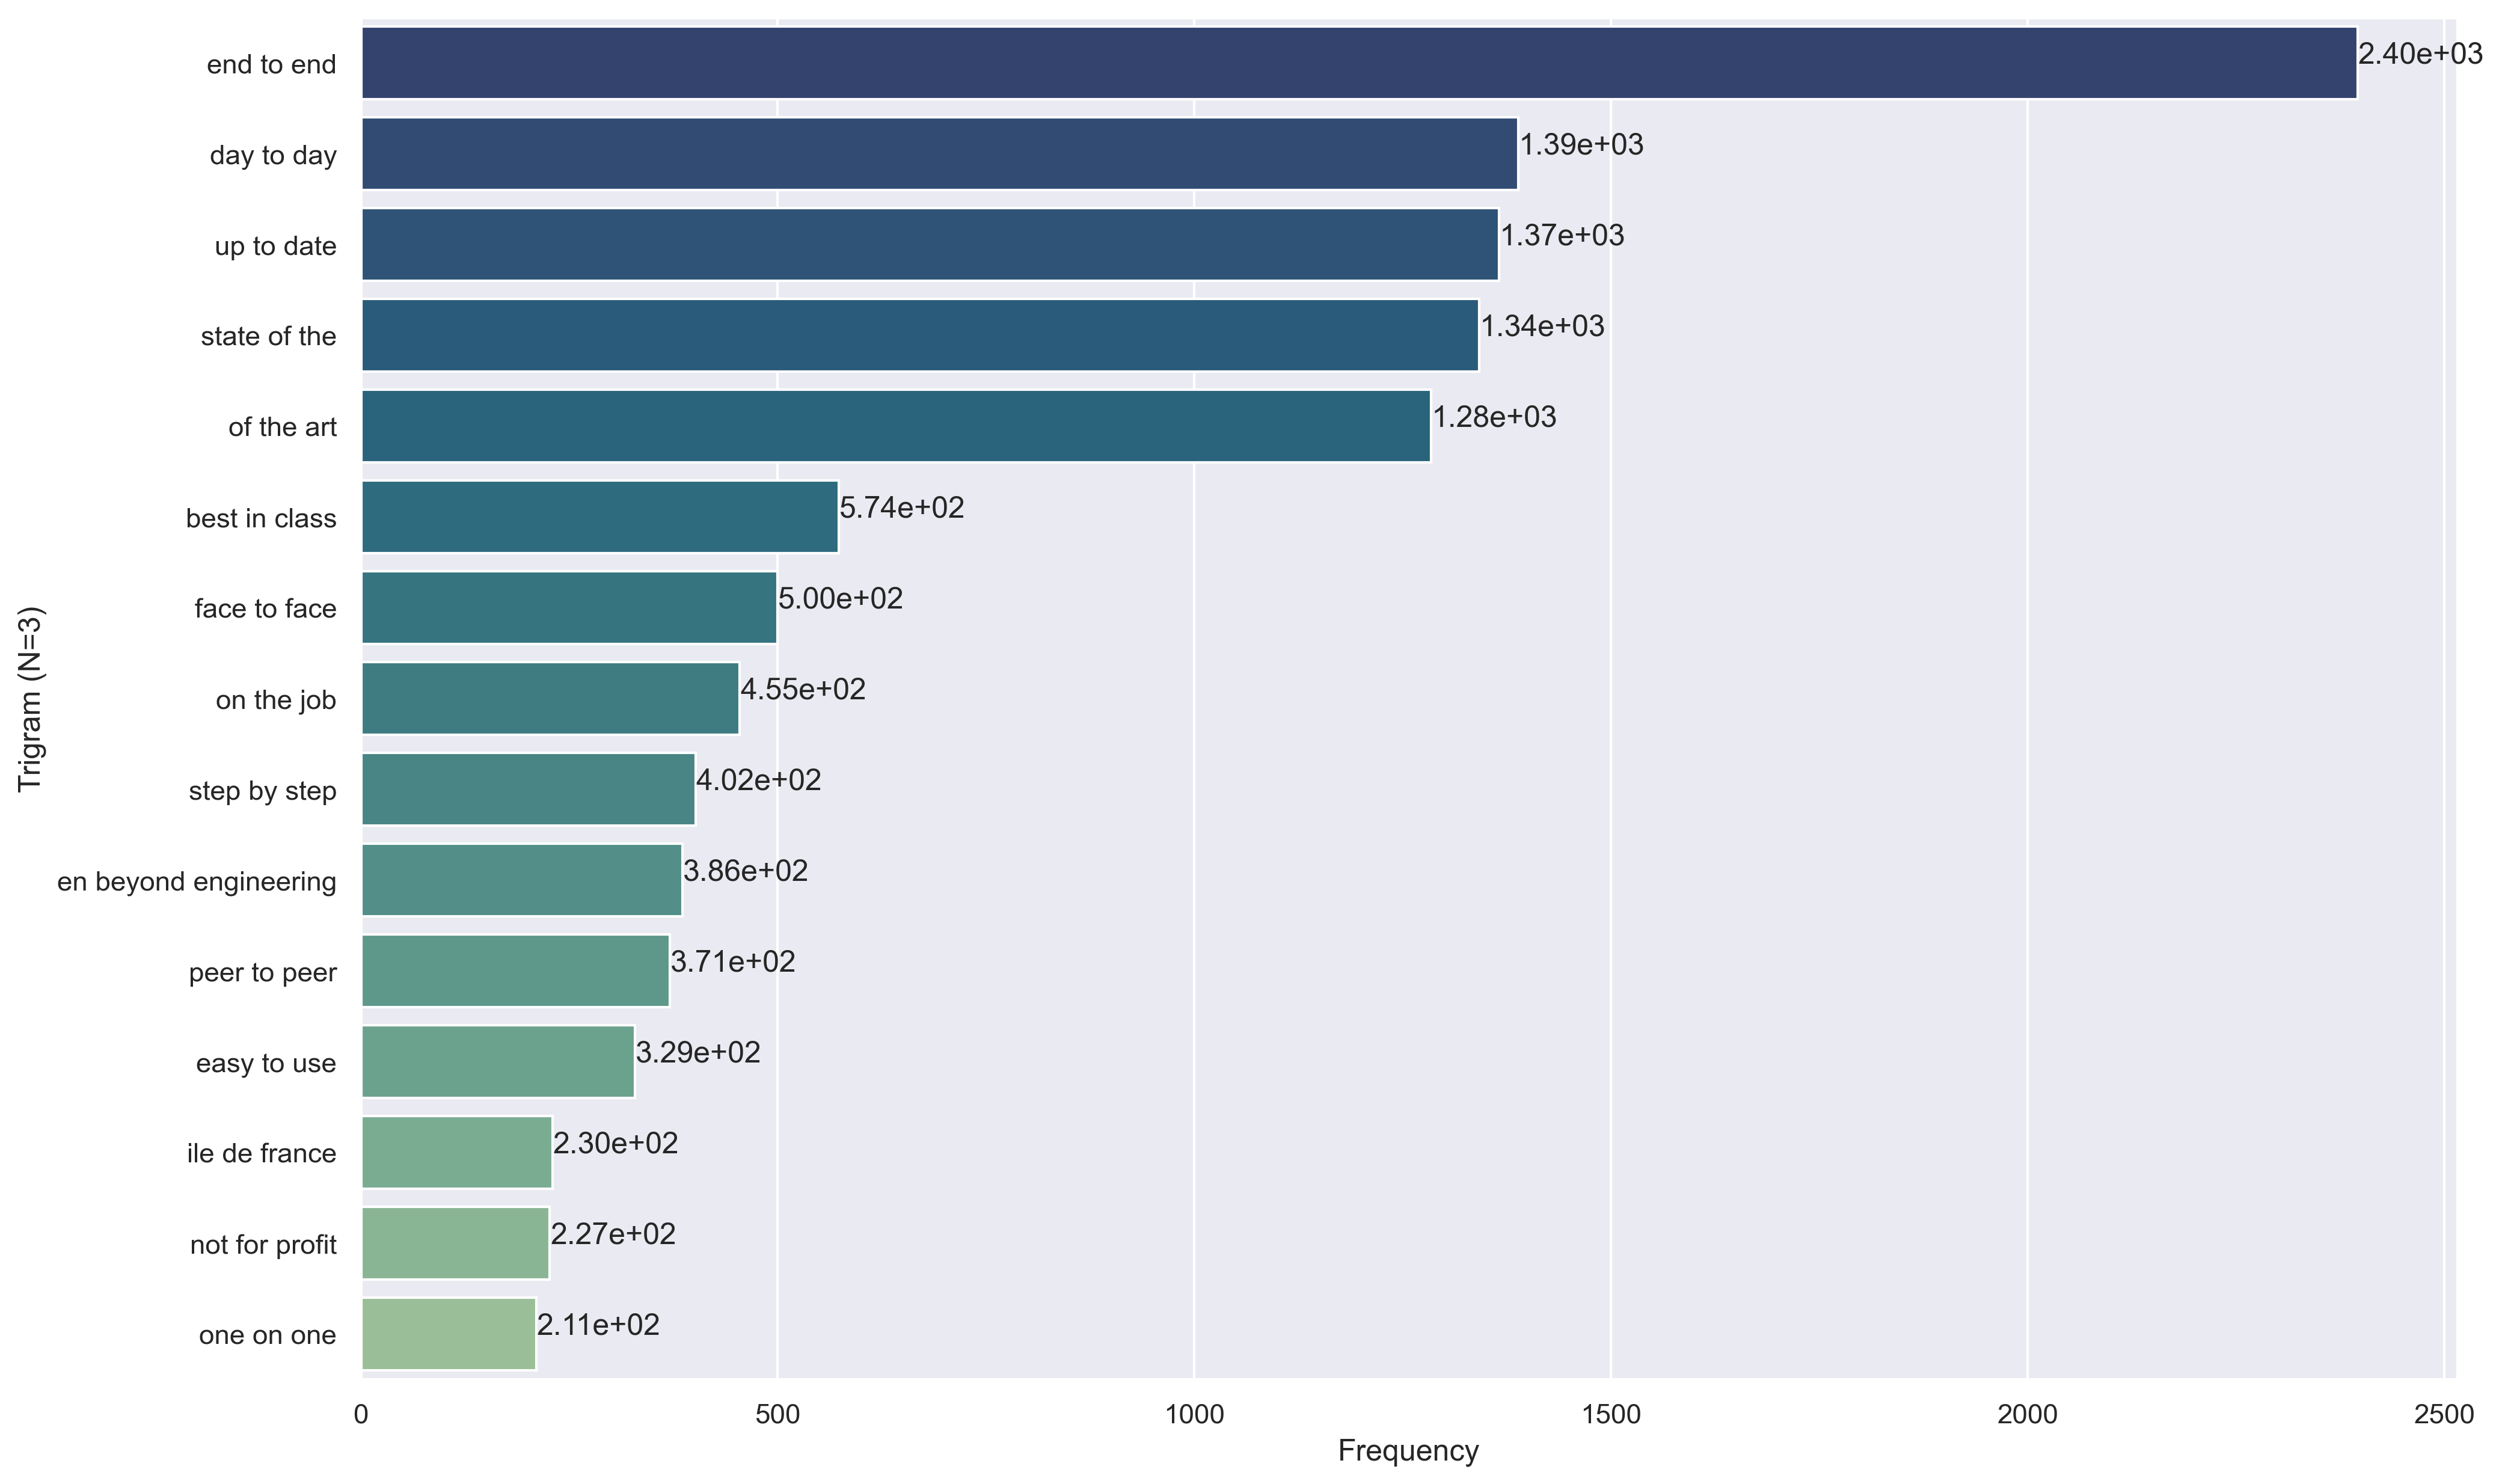

In [22]:
ax = sns.\
    barplot(
        data=pd.DataFrame(top_n_trigrams[:15], columns=["Trigram", "Frequency"]), 
        y="Trigram", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='Trigram (N=3)')

In [23]:
top_n_4grams = eda_methods.get_top_ngram(eda.corpus_full, 4)

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, '4-grams (N=4)')]

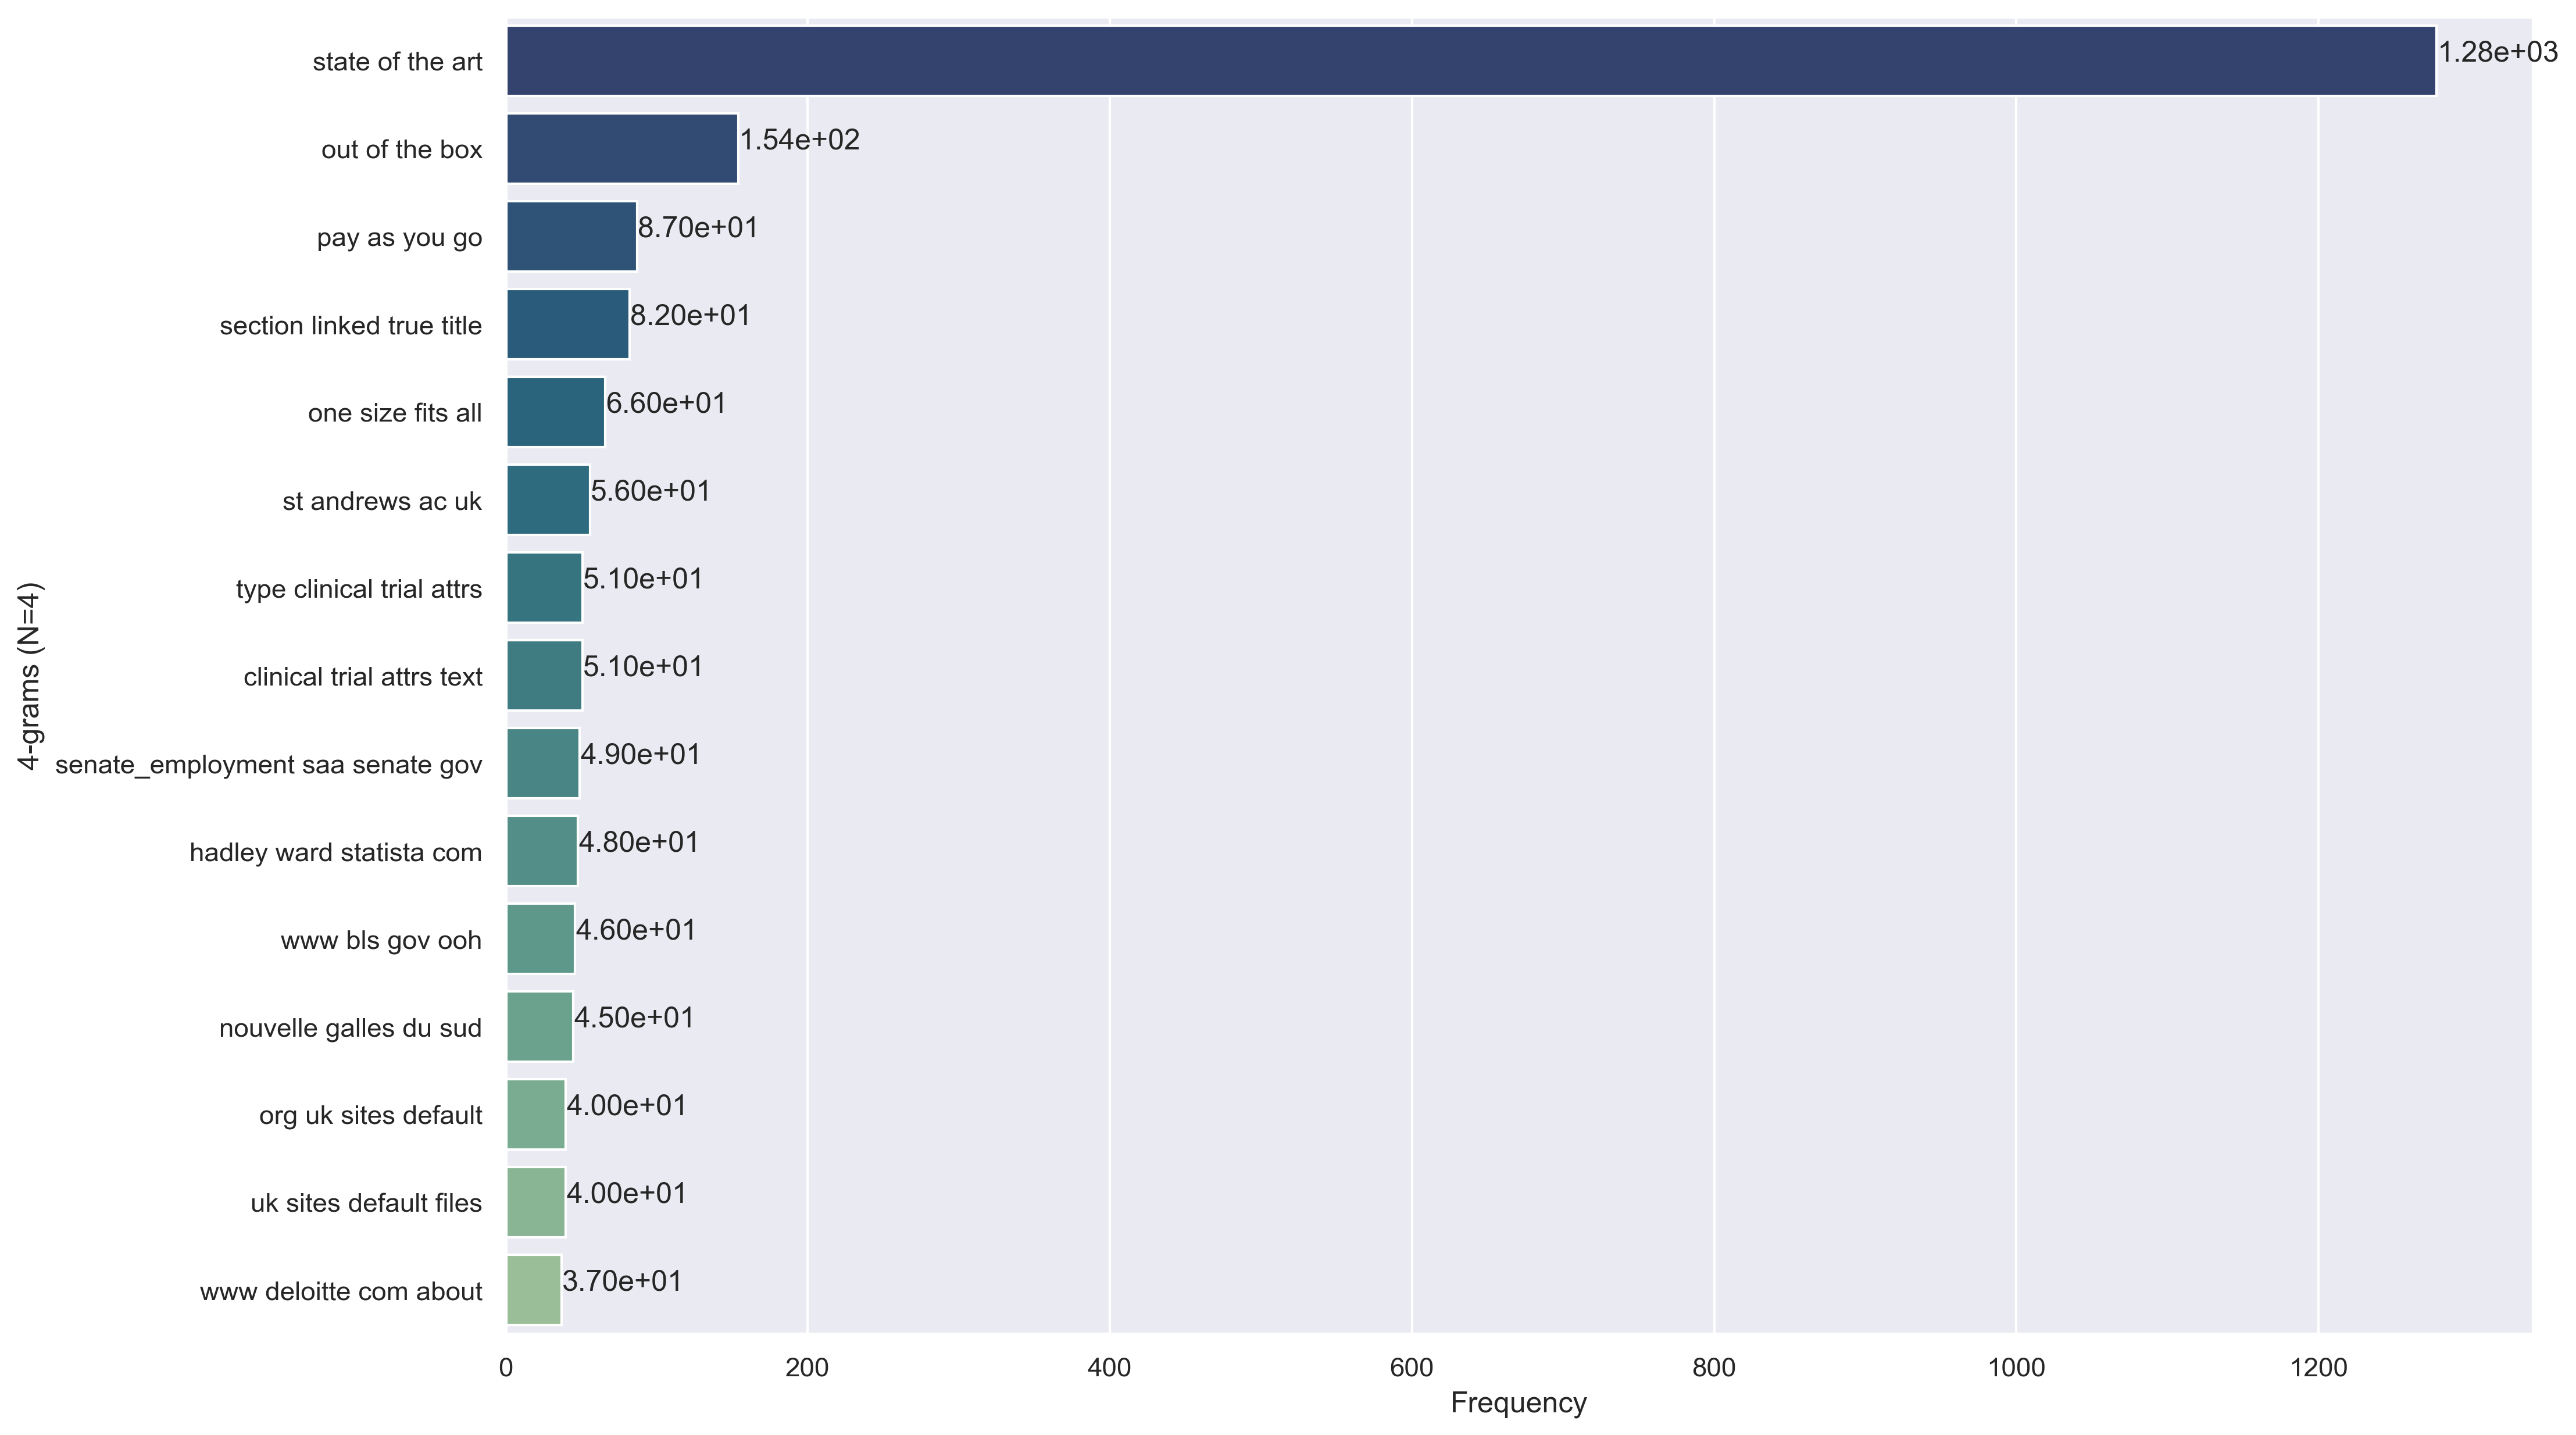

In [24]:
ax = sns.\
    barplot(
        data=pd.DataFrame(top_n_4grams[:15], columns=["4-grams", "Frequency"]), 
        y="4-grams", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='4-grams (N=4)')

In [25]:
top_n_5grams = eda_methods.get_top_ngram(eda.corpus_full, 5)

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, '5-grams (N=5)')]

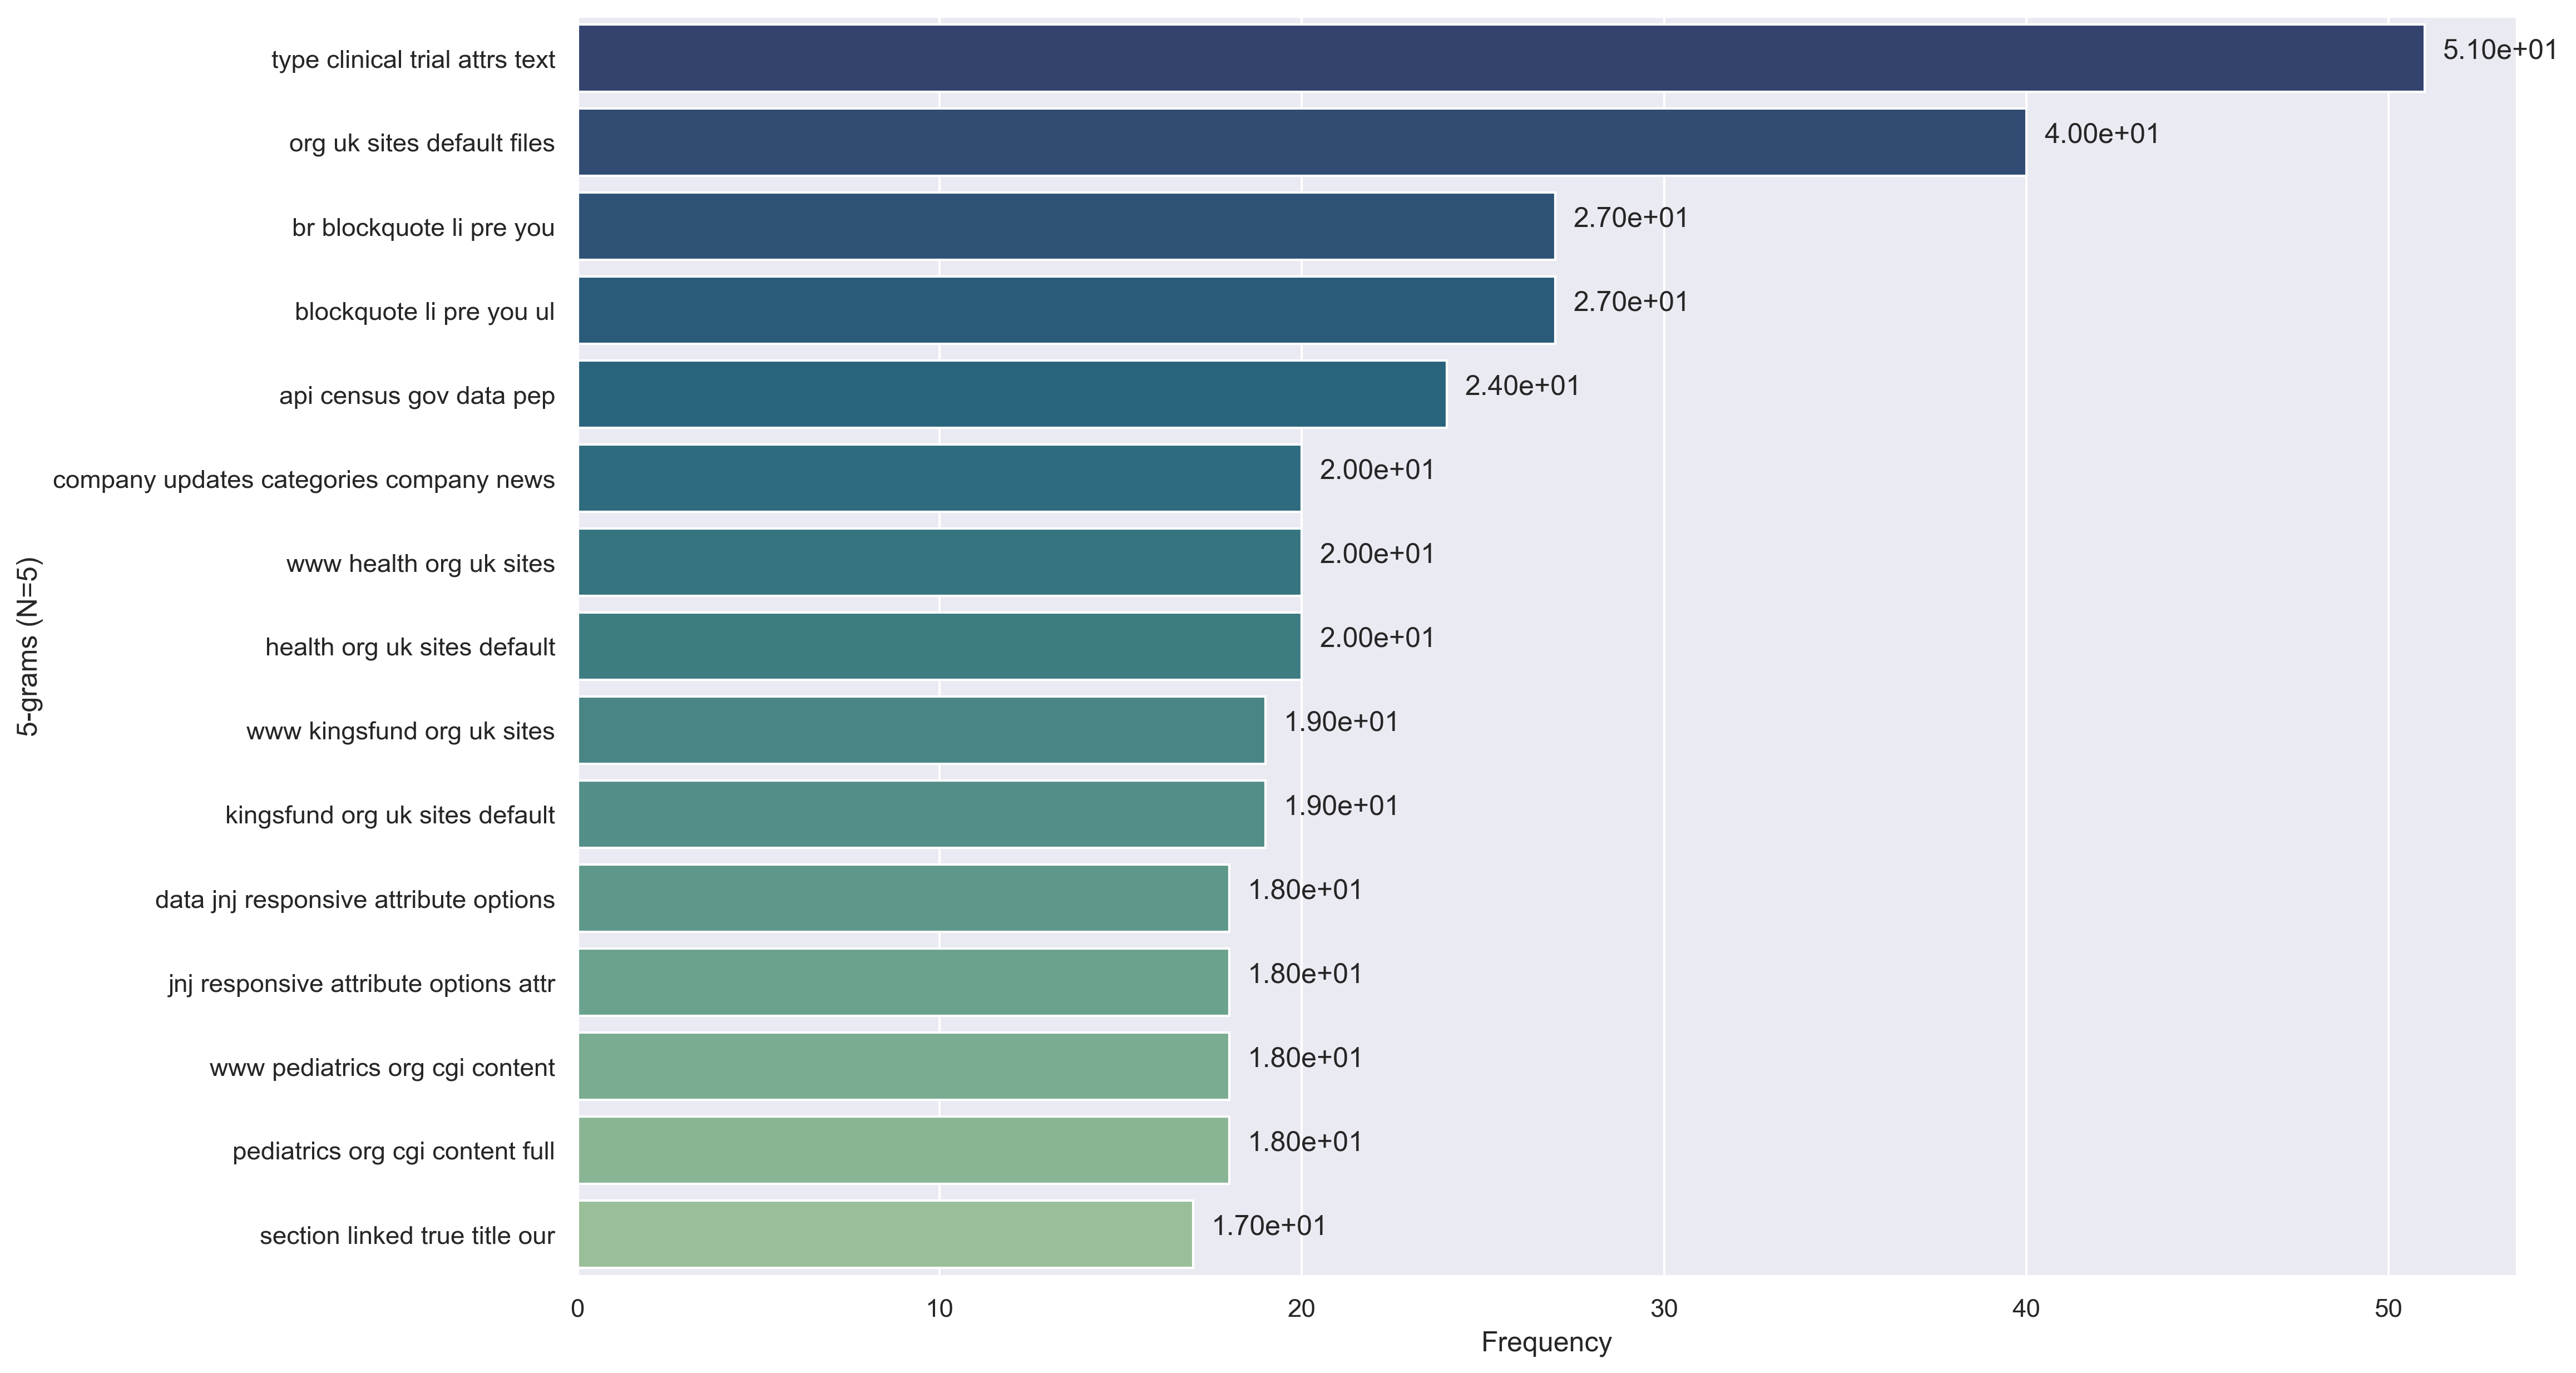

In [26]:
ax = sns.\
    barplot(
        data=pd.DataFrame(top_n_5grams[:15], columns=["5-grams", "Frequency"]), 
        y="5-grams", 
        x="Frequency",
        palette="crest_r")
show_values(ax, "h", space=0.5)
ax.set(
    xlabel='Frequency', 
    ylabel='5-grams (N=5)')

In [27]:
LDA = eda_methods.get_lda_objects(gensim_dic=eda.gensim_dic, bow_corpus=eda.bow_corpus)

In [28]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

In [29]:
LDA.show_topics()

[(4,
  '0.033*"data" + 0.019*"science" + 0.018*"university" + 0.015*"student" + 0.014*"learning" + 0.012*"research" + 0.010*"course" + 0.009*"study" + 0.006*"machine" + 0.006*"analytics"'),
 (11,
  '0.046*"cloud" + 0.026*"data" + 0.024*"service" + 0.020*"solution" + 0.015*"aws" + 0.012*"management" + 0.011*"microsoft" + 0.011*"customer" + 0.011*"azure" + 0.011*"enterprise"'),
 (19,
  '0.077*"health" + 0.030*"care" + 0.027*"clinical" + 0.027*"patient" + 0.021*"medical" + 0.016*"healthcare" + 0.016*"disease" + 0.014*"study" + 0.013*"research" + 0.013*"drug"'),
 (7,
  '0.186*"engineering" + 0.092*"state" + 0.072*"united" + 0.058*"engineer" + 0.046*"california" + 0.029*"electrical" + 0.026*"manufacturing" + 0.025*"mechanical" + 0.019*"software" + 0.017*"estate"'),
 (14,
  '0.129*"index" + 0.077*"solactive" + 0.038*"market" + 0.037*"ibm" + 0.032*"usd" + 0.018*"global" + 0.017*"cap" + 0.016*"esg" + 0.013*"large" + 0.013*"mid"'),
 (1,
  '0.013*"career" + 0.012*"work" + 0.011*"opportunity" + 0

In [30]:
plot_lda_vis(LDA, eda.bow_corpus, eda.gensim_dic)

/Users/Mehdi/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/Mehdi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Mehdi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Mehdi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Mehdi/opt/anaconda3/lib/python3.9/s

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.138944  0.025974       1        1  11.353968
10    -0.088885 -0.168992       2        1  10.926473
4     -0.124168 -0.066602       3        1  10.176212
12    -0.131703  0.041051       4        1   9.277247
15    -0.127681 -0.038982       5        1   7.724174
3     -0.061177 -0.155089       6        1   6.735192
2     -0.112610  0.146275       7        1   6.589191
1     -0.117380  0.026835       8        1   6.072838
18     0.031072  0.107144       9        1   5.204090
9     -0.090031  0.059369      10        1   5.103275
11    -0.069641  0.040093      11        1   5.026667
8      0.209333 -0.006164      12        1   2.764905
0      0.029587 -0.183978      13        1   2.700288
17    -0.120460  0.125667      14        1   2.581488
5      0.026610 -0.104506      15        1   2.197123
13    -0.087835  0.207126      16        1   1.909227
19     0.078694 -0.234049      17        1   1.740346
16     0.257000  0.125927      18        1   1.060286
7      0.372121  0.099160      19        1   0.494183
14     0.266100 -0.046259      20        1   0.362828, topic_info=             Term           Freq          Total Category  logprob  loglift
93    engineering   69589.000000   69589.000000  Default  30.0000  30.0000
515        united   77724.000000   77724.000000  Default  29.0000  29.0000
505         state   76158.000000   76158.000000  Default  28.0000  28.0000
92       engineer   85174.000000   85174.000000  Default  27.0000  27.0000
135           job  150767.000000  150767.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
783        single     569.402872    7168.393122  Topic20  -5.1256   3.0861
858         month     640.531337   15039.847783  Topic20  -5.0079   2.4628
159    management     768.994714   88995.163226  Topic20  -4.8251   0.8677
4602          low     493.070726    5673.287136  Topic20  -5.2695   3.1761
507       support     663.434301   69911.735178  Topic20  -4.9728   0.9614

[1784 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
49312      8  0.965893    'change
3333       1  0.995277  'hands-on
53357      5  0.982958  'security
8468      16  0.991418       -eur
8227      19  0.776658    -system
...      ...       ...        ...
4614      20  0.013724      you.s
10854      7  0.982665     zabbix
14010     14  0.987629     zeplin
47001      6  0.050642     zoning
47001     13  0.949060     zoning

[10573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 5, 13, 16, 4, 3, 2, 19, 10, 12, 9, 1, 18, 6, 14, 20, 17, 8, 15])

In [32]:
eda.corpus_full

['core',
 'for',
 'tech',
 'is',
 'looking',
 'for',
 'its',
 'next',
 'rockstars',
 'to',
 'join',
 'the',
 'tech',
 'team!',
 'want',
 'to',
 'join',
 'an',
 'exceptional',
 'team',
 'of',
 'deep',
 'technology',
 'pioneers',
 'and',
 'impact',
 'safety',
 'on',
 'the',
 'road',
 '?',
 'core',
 'for',
 'tech',
 'is',
 'the',
 'first',
 'ever',
 'drowsy',
 'driving',
 'prevention',
 'system.',
 'based',
 'on',
 'heart',
 'rate',
 'variability,',
 'our',
 'multi-patented',
 'technology',
 'will',
 'radically',
 'change',
 'the',
 'level',
 'of',
 'safety',
 'on',
 'the',
 'road.',
 'active',
 'fatigue',
 'or',
 'passive',
 'fatigue',
 'in',
 'level',
 'autonomous',
 'cars?',
 'core',
 'for',
 'tech',
 'detects',
 'the',
 'early',
 'signs',
 'and',
 'reacts',
 '!',
 'this',
 'is',
 'a',
 'unique',
 'opportunity',
 'to',
 'have',
 'a',
 'strong',
 'and',
 'positive',
 'impact',
 'on',
 'thousands',
 'of',
 'drivers',
 'with',
 'technical',
 'and',
 'management',
 'responsibilities.',
 'w

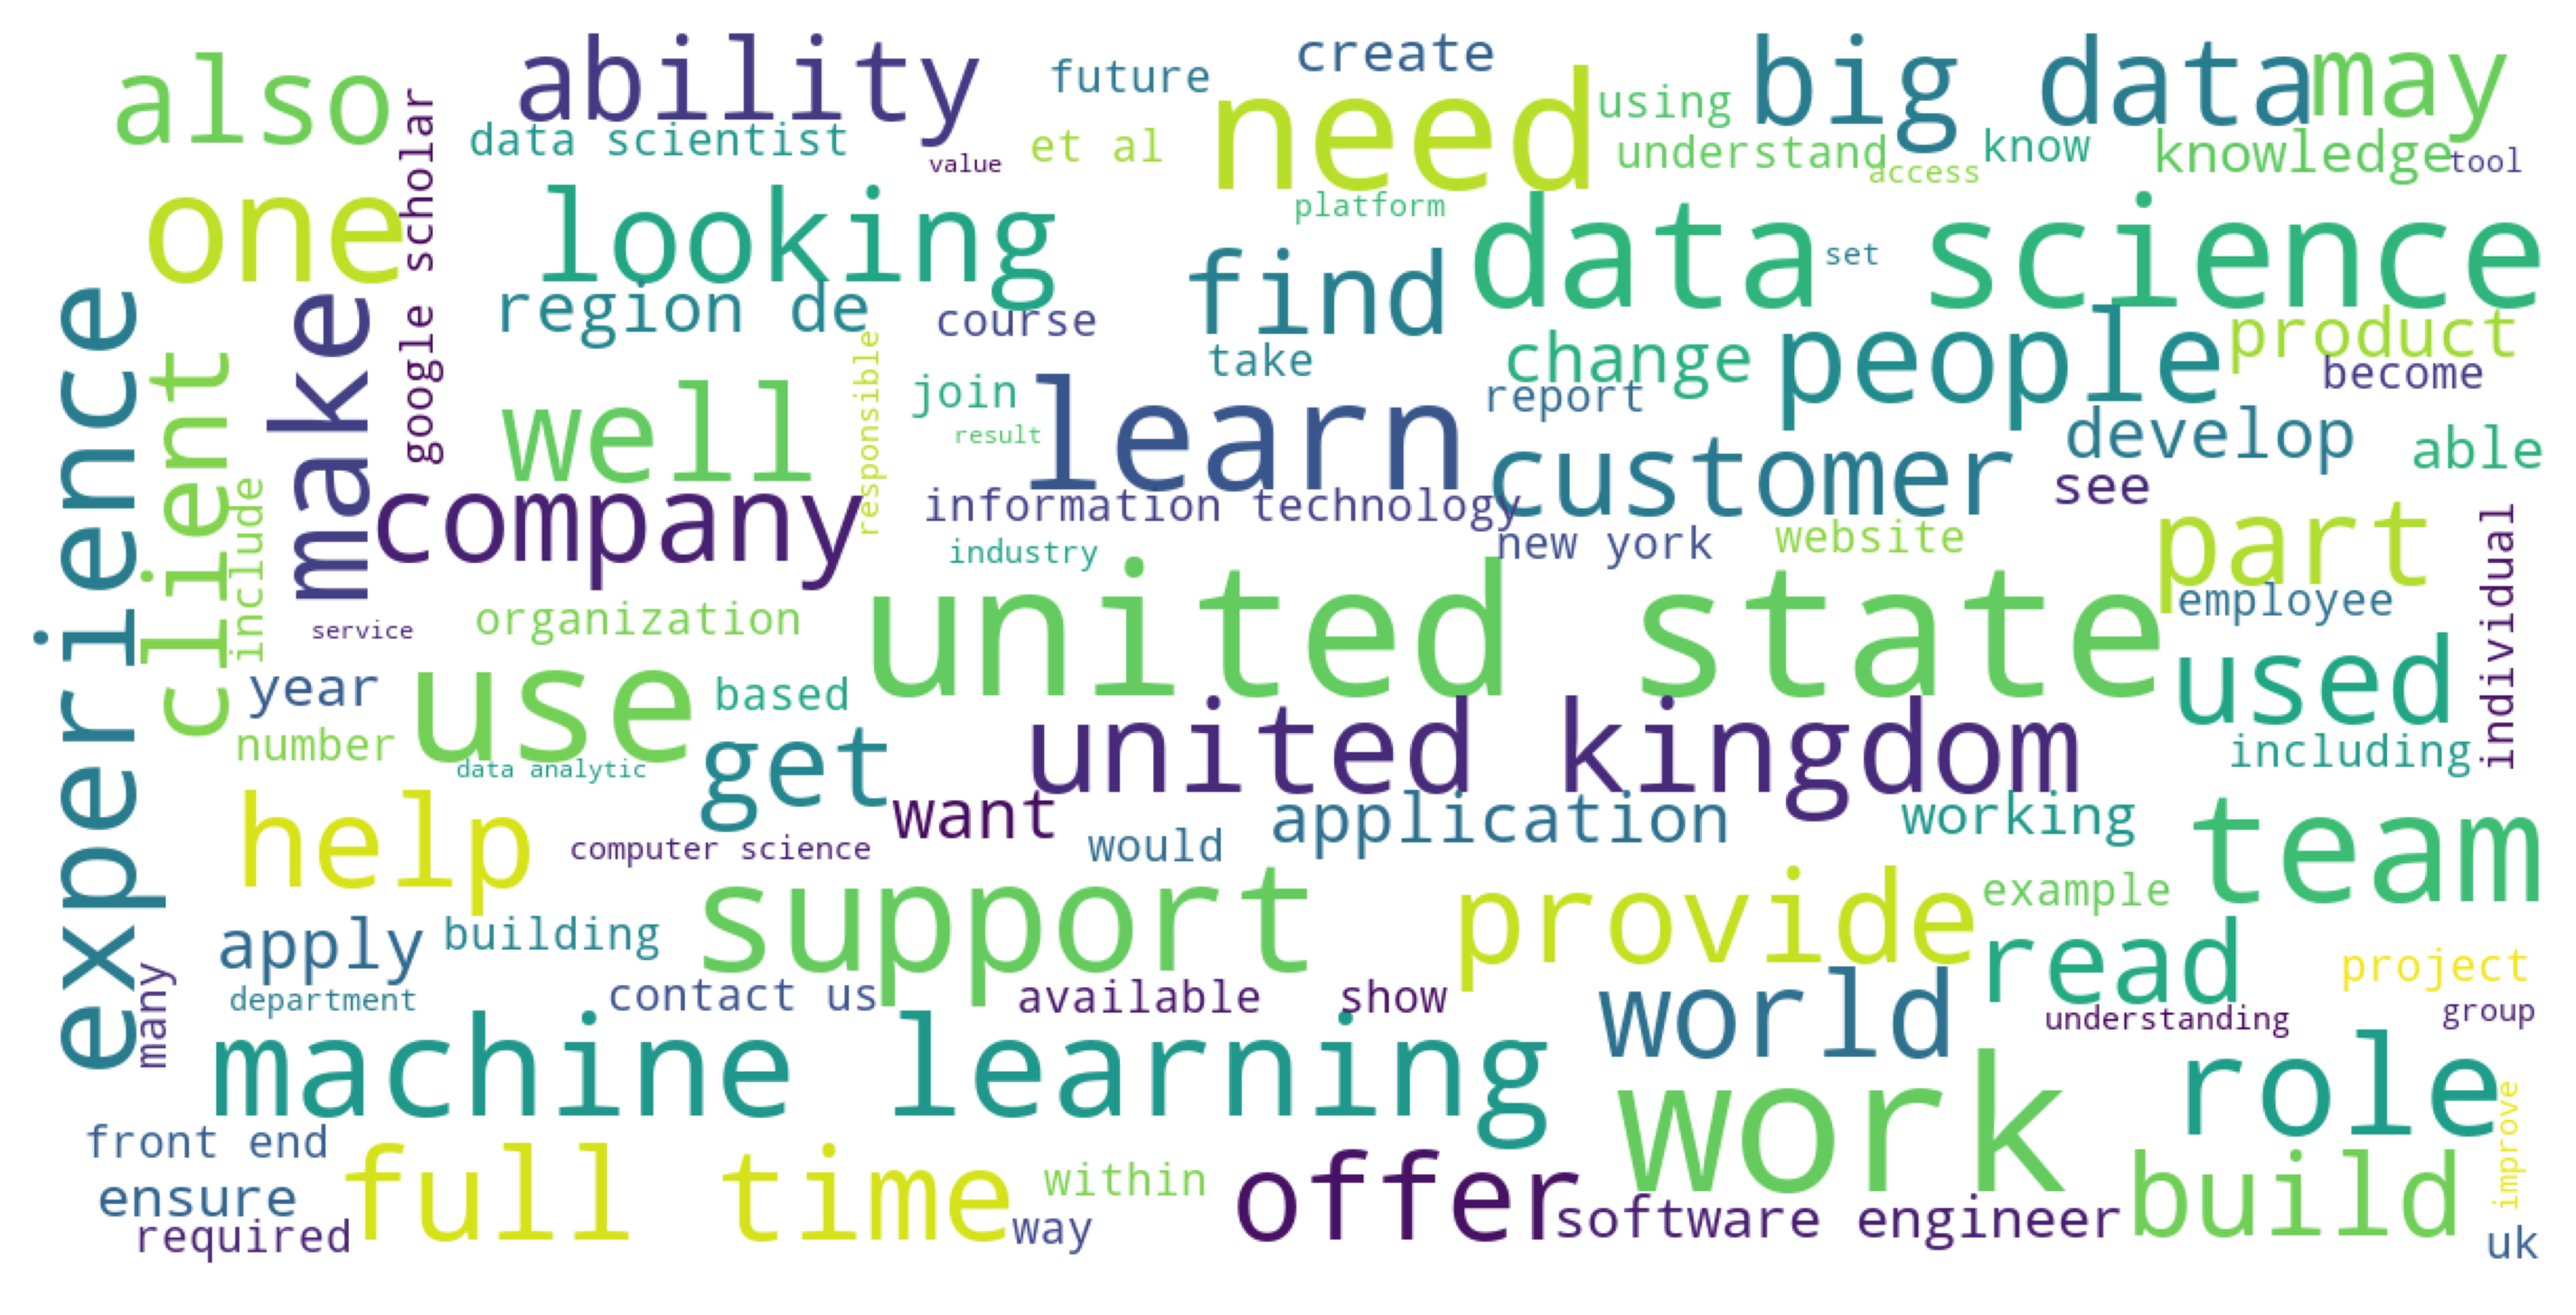

In [33]:
WCmodel = eda_methods.get_wordcloud(' '.join(eda.corpus_full))

In [36]:
fig = plt.figure(1, figsize=(12, 12), dpi=1200)
plt.axis('off')

plt.imshow(WCmodel)
plt.show()